# Прогноз удовлетворённости сотрудника работой в компании

## Описание исследования
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

## Цель исследования
Построить модели для предсказания оттока сотрудников, чтобы снизить риски компании и избежать финансовых потерь.

## Задачи исследования
Нужно построить две предсказательные модели:
* Первая сможет предсказать уровень удовлетворённости сотрудника
* Вторая сможет предсказать увольнение сотрудника из компании

## Исходные данные
Компания предоставила данные с характеристиками сотрудников компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

В нашем распоряжении есть пять файлов с табличными данными в формате csv: `train_job_satisfaction_rate`, `test_features`, `test_target_job_satisfaction_rate`, `train_quit` и `test_target_quit`. Входные признаки тестовой выборки одинаковы для обеих задач.

В данных есть следующие признаки:
* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## План исследования

***[Часть 1. Загрузка данных](#dataloading)***

***[Часть 2. Предобработка данных:](#datapreprocessing)***
* [1. Предобработка train_job_satisfaction_rate](#pre_train_rate)
* [2. Предобработка test_features](#pre_test_features)
* [3. Предобработка test_target_job_satisfaction_rate](#pre_test_rate)
* [4. Предобработка train_quit](#pre_train_quit)
* [5. Предобработка test_target_quit](#pre_test_quit)

***[Часть 3. Исследовательский анализ данных:](#eda)***
* [1. Анализ train_job_satisfaction_rate](#eda_tr_rate)
* [2. Анализ test_features](#eda_test_fe)
* [3. Анализ test_target_job_satisfaction_rate](#eda_test_ra)
* [4. Анализ train_quit](#eda_train_quit)
* [5. Анализ test_target_quit](#eda_test_tar_quit)
* [6. Проверим гипотезу о связи job_satisfaction_rate и quit](#hypo)

***[Часть 4. Корреляционный анализ:](#corr)***
* [1. Связь с целевым признаком в train_job_satisfaction_rate](#corr_rate)
* [2. Связь с целевым признаком в train_quit](#corr_quit)
* [3. Связь с целевыми признаками в тестовой выборке](#corr_test)

***[Часть 5. Задача 1. Предсказание уровня удовлетворённости сотрудника:](#first)***
* [1. Подготовка данных](#prep1)
* [2. Имплементация метрики SMAPE](#metric)
* [3. Моделирование и подбор гиперпараметров](#model1)

***[Часть 6. Задача 2. Предсказание увольнения сотрудника из компании:](#first)***
* [1. Подготовка данных](#prep2)
* [2. Моделирование и подбор гиперпараметров](#model2)

***[Часть 7. Вывод](#summary)***


<a id='dataloading'></a>
## Загрузка данных
Импортирование нужных библиотек

In [1]:
!pip install scikit-learn -U -q
!pip install phik -q
!pip install imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings
warnings.simplefilter("ignore")

from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier, DummyRegressor

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', titlesize=16, titlepad=10)

Загрузка датасетов

In [2]:
try:
    train_job_satisfaction_rate = pd.read_csv('~/datasets/employees_satisfaction/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('~/datasets/employees_satisfaction/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('~/datasets/employees_satisfaction/test_target_job_satisfaction_rate.csv')
    train_quit = pd.read_csv('~/datasets/employees_satisfaction/train_quit.csv')
    test_target_quit = pd.read_csv('~/datasets/employees_satisfaction/test_target_quit.csv')
except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

Выведем первые 5 строк каждого датафрейма

In [3]:
display(train_job_satisfaction_rate.head())
display(test_features.head())
display(test_target_job_satisfaction_rate.head())
display(train_quit.head())
display(test_target_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные загрузились и выводятся правильно, приступим к предобработке данных

<a id='datapreprocessing'></a>
## Предобработка данных
Рассмотрим датафреймы по отдельности
<a id='pre_train_rate'></a>
### Предобработка train_job_satisfaction_rate
Выведем основную информацию

In [4]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В столбцах `dept` и `level` есть NaN-значения. Посмотрим на записи с пропусками.

In [5]:
train_job_satisfaction_rate[train_job_satisfaction_rate.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Эти пропуски помешают моделям, но их не так много. Требования заказчика включают заполнение пропусков в пайплайне, так что избавимся от этих пропусков позже.

Проверим, есть ли значения-заглушки или неявные дубликаты в категориальных столбцах.

In [6]:
for col in train_job_satisfaction_rate.select_dtypes(exclude='number').columns:
    print(f'Уникальные значения столбца \033[1m{col}\033[m:')
    print(train_job_satisfaction_rate[col].unique(), '\n')

Уникальные значения столбца dept:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

Уникальные значения столбца level:
['junior' 'middle' 'sinior' nan] 

Уникальные значения столбца workload:
['medium' 'high' 'low'] 

Уникальные значения столбца last_year_promo:
['no' 'yes'] 

Уникальные значения столбца last_year_violations:
['no' 'yes'] 



Заглушек и неявных дубликатов нет. Посмотрим, нет ли в датафрейме повторений `id`.

In [7]:
train_job_satisfaction_rate['level'].replace('sinior', 'senior', inplace=True)
print('Число уникальных \033[1mid\033[m:', train_job_satisfaction_rate['id'].nunique())

Число уникальных id: 4000


Все значения столбца `id` уникальны. Сделаем `id` индексовым столбцом и проверим, есть ли дубликаты записей.

In [8]:
train_job_satisfaction_rate.set_index('id', drop=True, inplace=True)
print('Число полных дубликатов:', train_job_satisfaction_rate.duplicated().sum())

Число полных дубликатов: 245


Дубликаты есть, и они никак не помогут моделям при обучении, их придётся удалить.

In [9]:
train_job_satisfaction_rate.drop_duplicates(inplace=True)
train_job_satisfaction_rate.shape

(3755, 9)

Дубликатов теперь нет и с данными в `train_job_satisfaction_rate` всё хорошо.

<a id='pre_test_features'></a>
### Предобработка test_features
Выведем основную информацию

In [10]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


NaN-значения есть, но так как это тестовая выборка, удалять записи нельзя. В ходе предсказания заполним пропуски в пайплайне.

Посмотрим на уникальные значения в категориальных столбцах.

In [11]:
test_features['level'].replace('sinior', 'senior', inplace=True)
for col in test_features.select_dtypes(exclude='number').columns:
    print(f'Уникальные значения столбца \033[1m{col}\033[m:')
    print(test_features[col].unique(), '\n')

Уникальные значения столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

Уникальные значения столбца level:
['junior' 'middle' 'senior' nan] 

Уникальные значения столбца workload:
['medium' 'low' 'high' ' '] 

Уникальные значения столбца last_year_promo:
['no' 'yes'] 

Уникальные значения столбца last_year_violations:
['no' 'yes'] 



Кроме NaN-значений есть пробелы, их тоже нужно заполнить перед предсказанием.

Посмотрим, нет ли в датафрейме повторений id.

In [12]:
print('Число уникальных \033[1mid\033[m:', test_features['id'].nunique())

Число уникальных id: 2000


Все значения столбца `id` уникальны. Сделаем `id` индексовым столбцом.

In [13]:
test_features.set_index('id', drop=True, inplace=True)
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


На данный момент предобработка `test_features` завершена, пропуски заполним в пайплайне.

<a id='pre_test_rate'></a>
### Предобработка test_target_job_satisfaction_rate
Выведем основную информацию

In [14]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Посмотрим, есть ли в датафрейме повторения `id`.

In [15]:
print('Число уникальных \033[1mid\033[m:', test_target_job_satisfaction_rate['id'].nunique())

Число уникальных id: 2000


Все значения столбца `id` уникальны. Сделаем `id` индексовым столбцом.

In [16]:
test_target_job_satisfaction_rate.set_index('id', drop=True, inplace=True)
test_target_job_satisfaction_rate.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


<a id='pre_train_quit'></a>
### Предобработка train_quit
Выведем основную информацию

In [17]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


NaN-значений нет. Проверим, есть ли значения-заглушки или неявные дубликаты в категориальных столбцах.

In [18]:
train_quit['level'].replace('sinior', 'senior', inplace=True)
for col in train_quit.select_dtypes(exclude='number').columns:
    print(f'Уникальные значения столбца \033[1m{col}\033[m:')
    print(train_quit[col].unique(), '\n')

Уникальные значения столбца dept:
['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

Уникальные значения столбца level:
['middle' 'junior' 'senior'] 

Уникальные значения столбца workload:
['high' 'medium' 'low'] 

Уникальные значения столбца last_year_promo:
['no' 'yes'] 

Уникальные значения столбца last_year_violations:
['no' 'yes'] 

Уникальные значения столбца quit:
['no' 'yes'] 



Заглушек и неявных дубликатов нет. Посмотрим, нет ли в датафрейме повторений `id`.

In [19]:
print('Число уникальных \033[1mid\033[m:', train_quit['id'].nunique())

Число уникальных id: 4000


Все значения столбца `id` уникальны. Сделаем `id` индексовым столбцом и проверим, есть ли дубликаты записей.

In [20]:
train_quit.set_index('id', drop=True, inplace=True)
print('Число полных дубликатов:', train_quit.duplicated().sum())

Число полных дубликатов: 1413


Дубликаты есть и их много, но они никак не помогут моделям при обучении, их придётся удалить.

In [21]:
train_quit.drop_duplicates(inplace=True)
train_quit.shape

(2587, 9)

Дубликатов теперь нет и с данными в `train_quit` всё хорошо.

<a id='pre_test_quit'></a>
### Предобработка test_target_quit
Выведем основную информацию

In [22]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Посмотрим, нет ли в целевом признаке неожиданных значений.

In [23]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

Значения те же, что и в тренировочной выборке. 

Посмотрим, есть ли в датафрейме повторения `id`.

In [24]:
print('Число уникальных \033[1mid\033[m:', test_target_quit['id'].nunique())

Число уникальных id: 2000


Все значения столбца `id` уникальны. Сделаем `id` индексовым столбцом.

In [25]:
test_target_quit.set_index('id', drop=True, inplace=True)
test_target_quit.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


В ходе предобработки мы избавились от дубликатов и пропусков в обучающих выборках, а также сделали `id` индексом для каждого датафрейма. В тестовой выборке пропуски заполним в пайплайне. 

Можем начать исследовательский анализ данных.

<a id='eda'></a>
## Исследовательский анализ данных

<a id='eda_tr_rate'></a>
### Анализ train_job_satisfaction_rate

Выведем статистическое описание числовых столбцов

In [26]:
train_job_satisfaction_rate.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


В описании выше не видно подозрительных значений.

Выведем гистограммы непрерывных числовых столбцов.

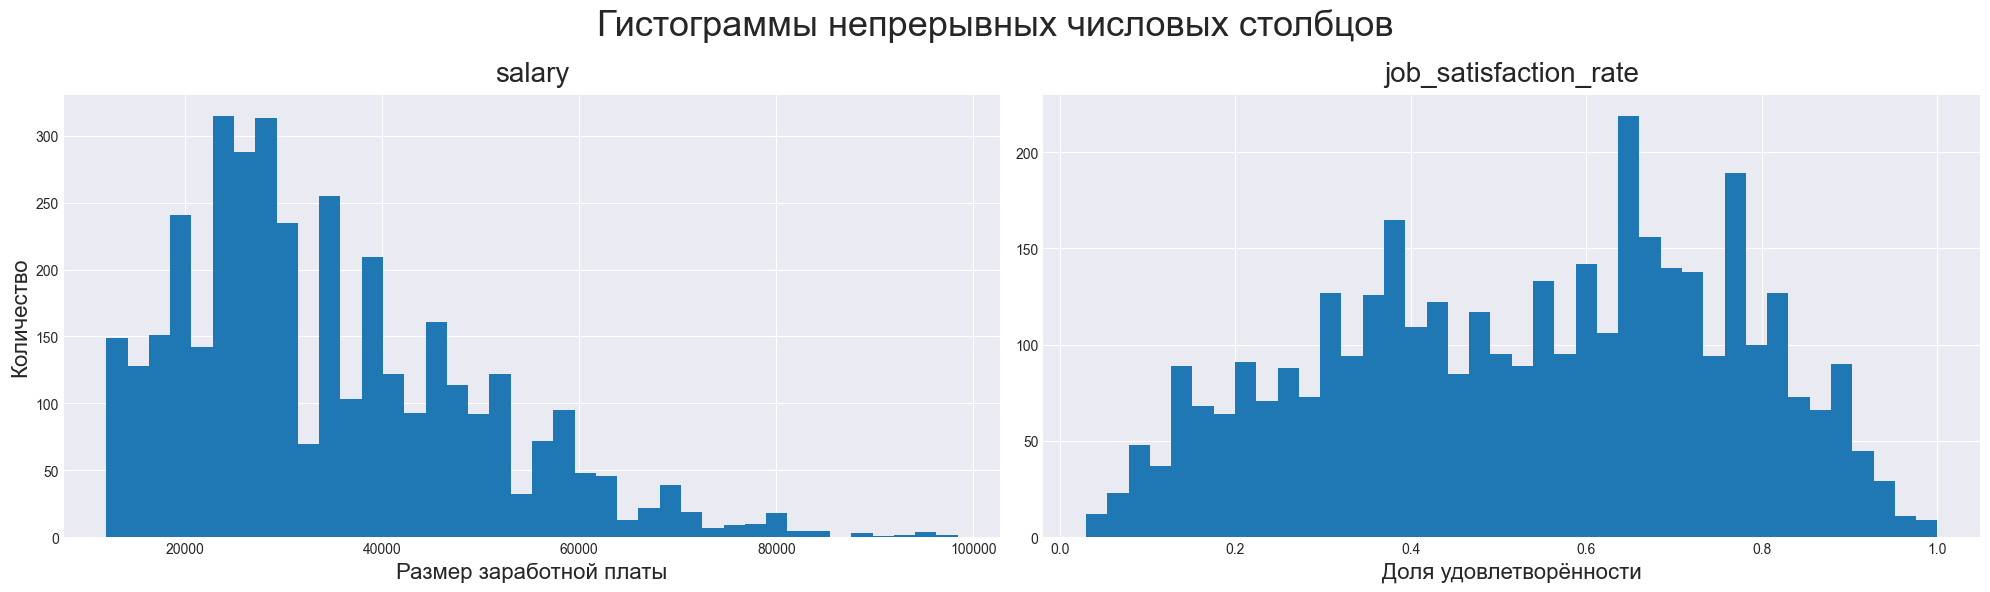

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=26)

axs[0].hist(train_job_satisfaction_rate['salary'], bins=40)
axs[1].hist(train_job_satisfaction_rate['job_satisfaction_rate'], bins=40)

axs[0].set_title('salary', fontsize=20)
axs[1].set_title('job_satisfaction_rate', fontsize=20)
axs[0].set_ylabel('Количество', fontsize=16)
axs[0].set_xlabel('Размер заработной платы', fontsize=16)
axs[1].set_xlabel('Доля удовлетворённости', fontsize=16);

Выведем столбцовые диаграммы дискретных числовых столбцов.

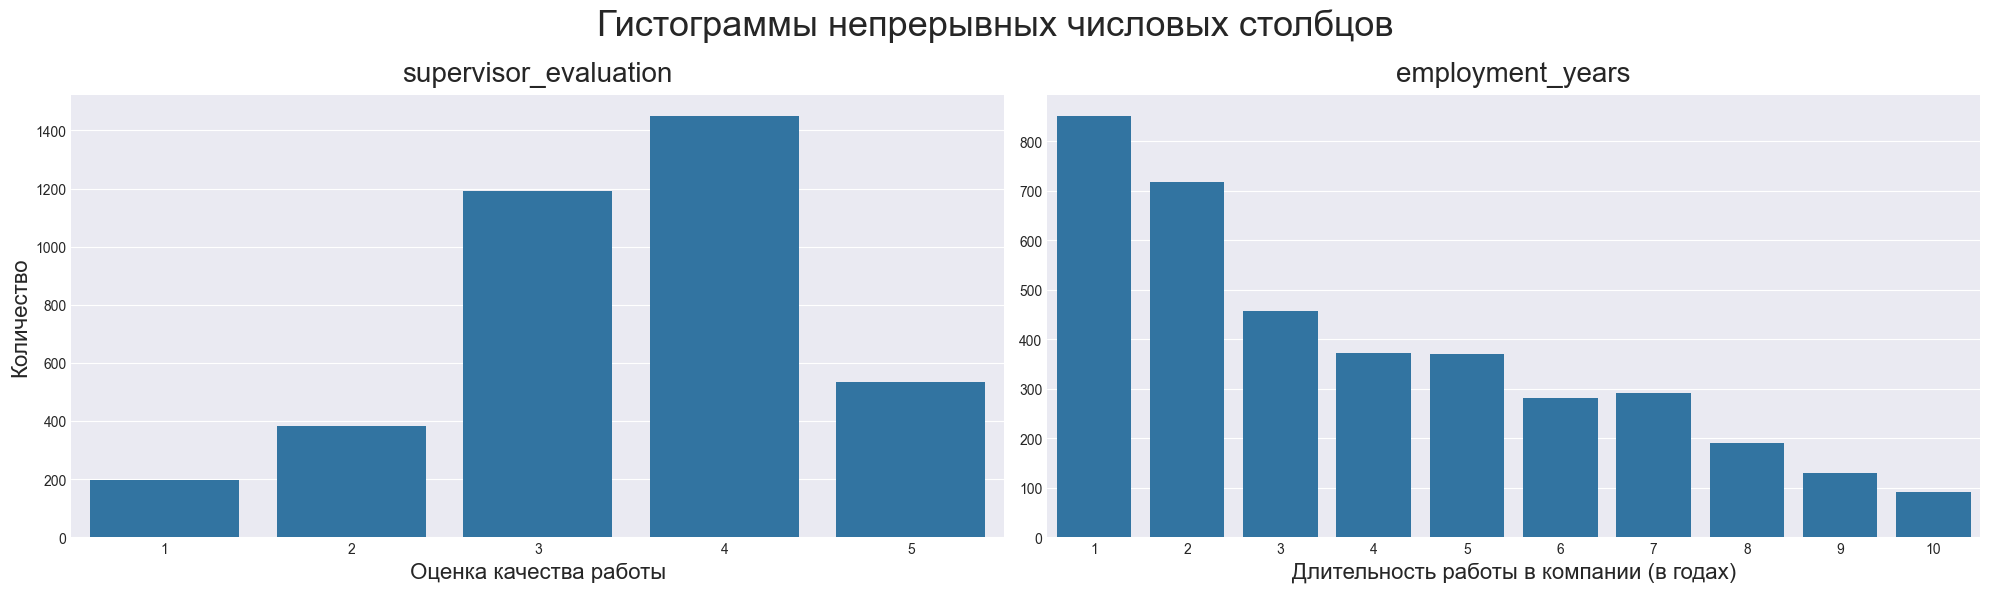

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=26)

sns.countplot(train_job_satisfaction_rate, x='supervisor_evaluation', ax=axs[0])
sns.countplot(train_job_satisfaction_rate, x='employment_years', ax=axs[1])

axs[0].set_title('supervisor_evaluation', fontsize=20)
axs[1].set_title('employment_years', fontsize=20)
axs[0].set_ylabel('Количество', fontsize=16)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('Оценка качества работы', fontsize=16)
axs[1].set_xlabel('Длительность работы в компании (в годах)', fontsize=16);

При подготовке данных к обучению `employment_years` и `supervisor_evaluation` стоит сделать категориальными из-за их дискретной природы.

Невооружённым глазом видно, что распределения `salary` и `job_satisfaction_rate` не являются нормальными. Посмотрим также на их ящики с усами.

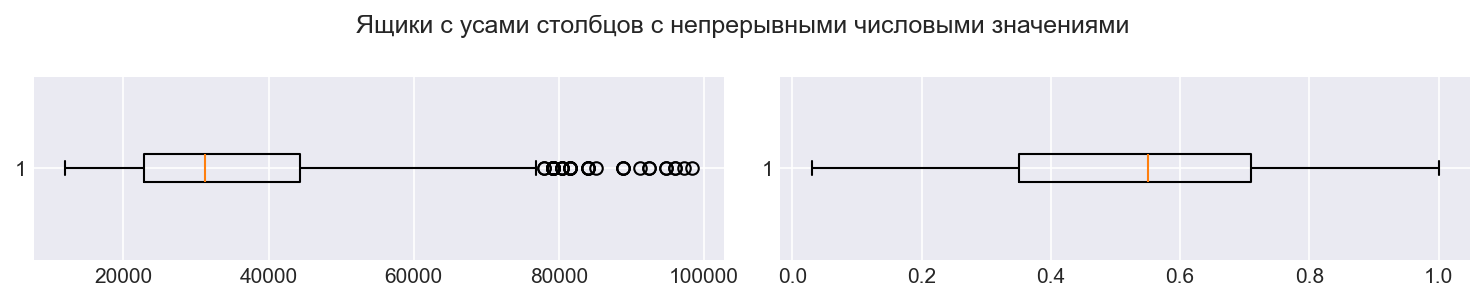

In [29]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 2))
fig.suptitle('Ящики с усами столбцов с непрерывными числовыми значениями', fontsize=12)

axs[0].boxplot(train_job_satisfaction_rate['salary'], vert=False)
axs[1].boxplot(train_job_satisfaction_rate['job_satisfaction_rate'], vert=False);

В `job_satisfaction_rate` нет выбросов. Есть несколько записей с несвойственно большими для распределения значениями в `salary`, однако эти цифры весьма правдоподобны и вряд ли являются аномальными.

Посмотрим на частотные характеристики категориальных столбцов.

In [30]:
train_job_satisfaction_rate.describe(exclude='number')

,dept,level,workload,last_year_promo,last_year_violations
count,3749,3751,3755,3755,3755
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1374,1699,1908,3635,3202


Выведем столбчатые диаграммы категориальных столбцов.

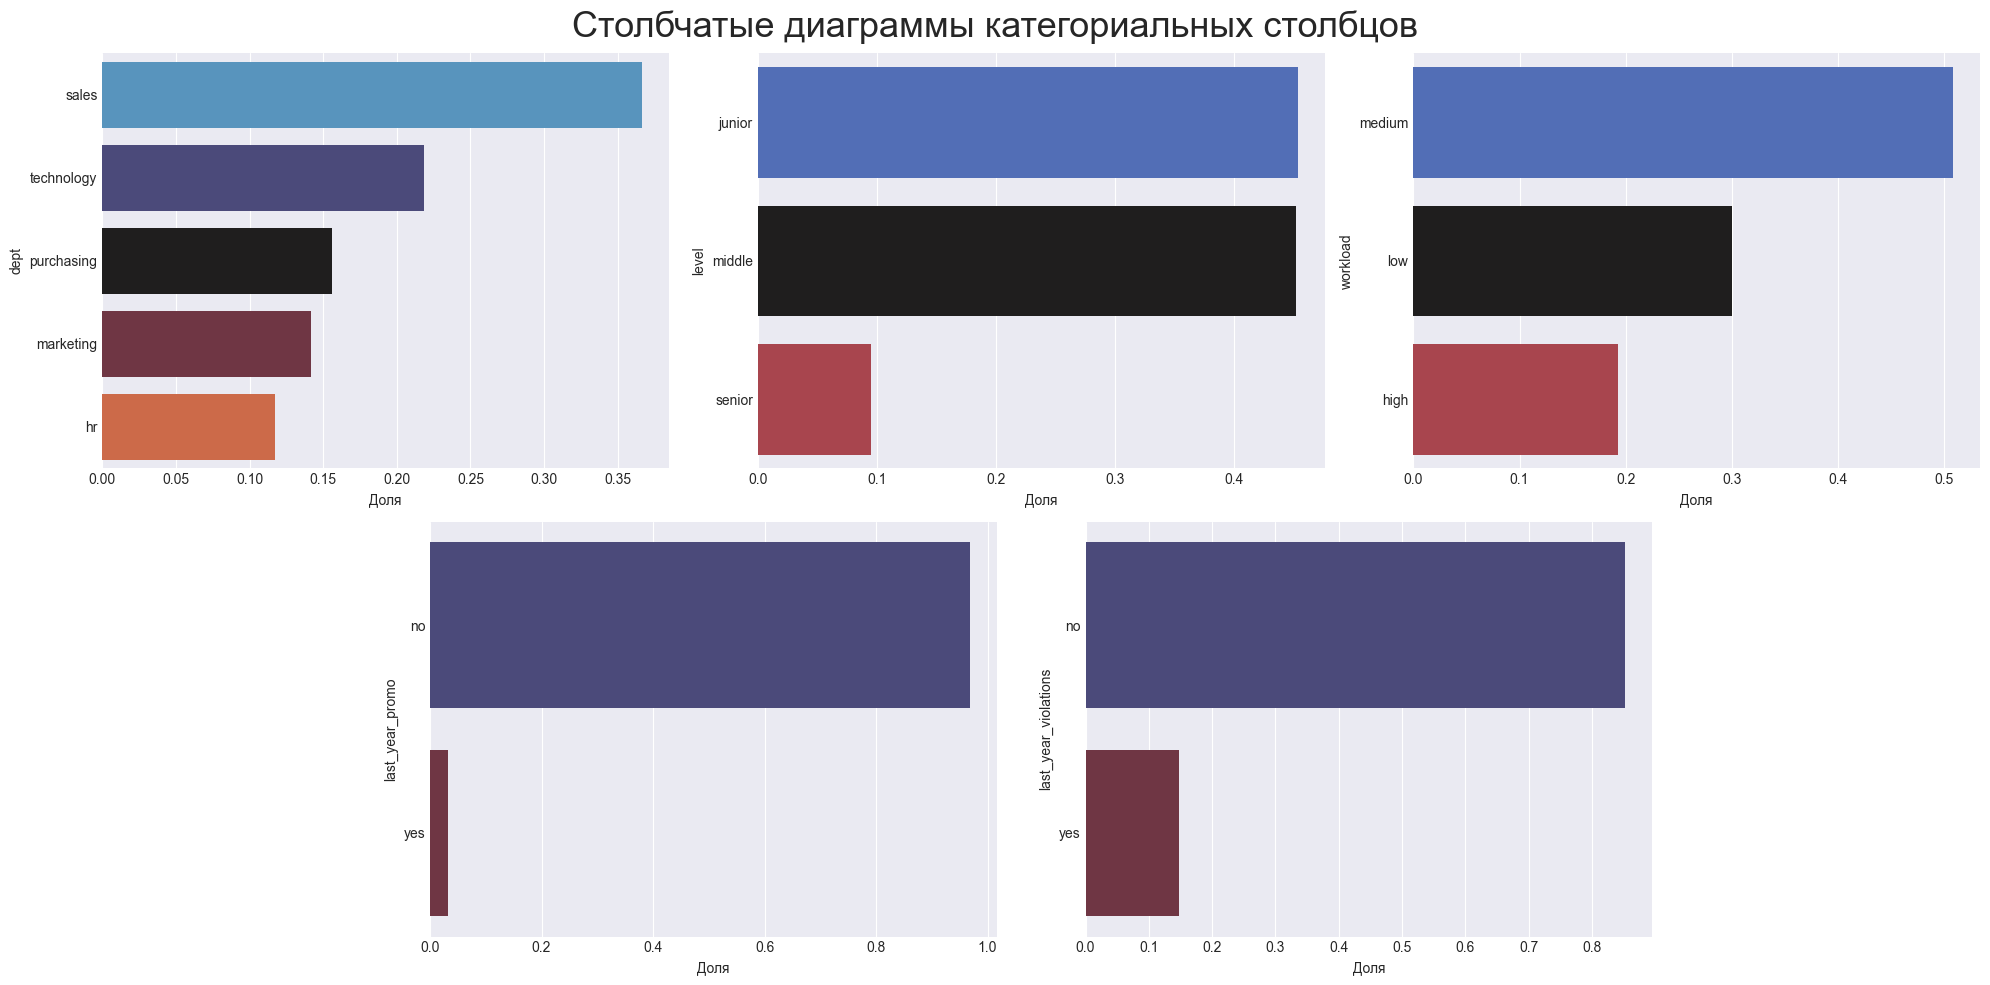

In [31]:
plt.figure(figsize=(20, 10))
plt.suptitle('Cтолбчатые диаграммы категориальных столбцов', fontsize=26)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

sns.barplot(data=train_job_satisfaction_rate['dept'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax1)
sns.barplot(data=train_job_satisfaction_rate['level'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax2)
sns.barplot(data=train_job_satisfaction_rate['workload'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax3)
sns.barplot(data=train_job_satisfaction_rate['last_year_promo'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax4);
sns.barplot(data=train_job_satisfaction_rate['last_year_violations'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax5);

ax1.set_xlabel('Доля')
ax2.set_xlabel('Доля')
ax3.set_xlabel('Доля')
ax4.set_xlabel('Доля')
ax5.set_xlabel('Доля');

Исходя из столбчатых диаграмм можно сделать следующие выводы:
* больше всего сотрудников работает в отделе продаж
* сотрудников уровня *senior* значительно меньше других
* заметно маленькое число повышений сотрудников
* в течении года большинство сотрудников не нарушало трудовой договор, но около 15% сотрудников всё же совершило проступок
* у большинства сотрудников средняя загруженность

<a id='eda_ref'></a>
*Выводы по исследовательскому анализу `train_job_satisfaction_rate`:*
* в целевом признаке нет выбросов. Это значит, что нет особенно редких значений, которые могли бы помешать при моделировании
* при подготовке данных к обучению `employment_years` и `supervisor_evaluation` стоит сделать категориальными из-за их дискретной природы
* есть несколько записей с несвойственно большими для распределения значениями в `salary`, однако эти цифры весьма правдоподобны и вряд ли являются аномальными
* заметно маленькое число повышений сотрудников
* в течении года большинство сотрудников не нарушало трудовой договор, но около 15% сотрудников всё же совершило проступок

<a id='eda_test_fe'></a>
### Анализ test_features

Выведем статистическое описание числовых столбцов

In [32]:
test_features.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Выведем гистограммы непрерывных числовых столбцов.

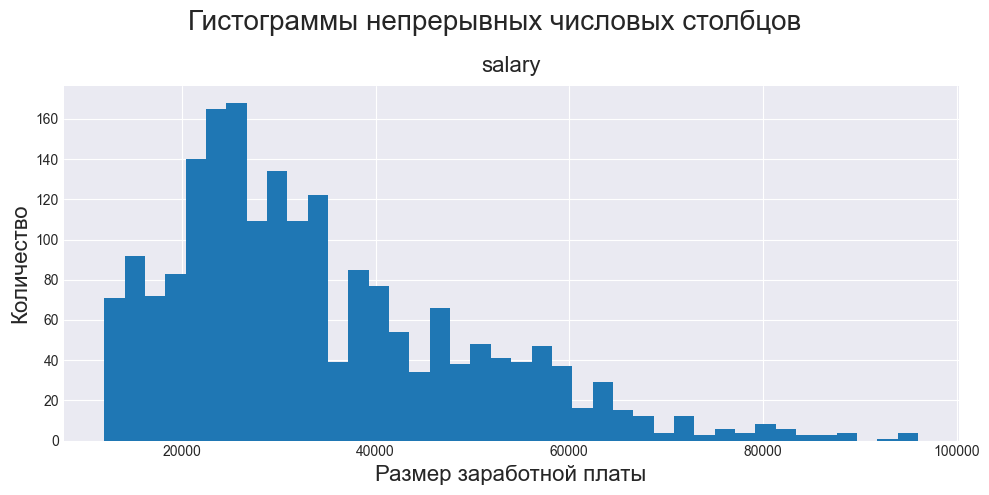

In [33]:
plt.figure(figsize=(10, 5))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=20)

plt.hist(test_features['salary'], bins=40)

plt.title('salary', fontsize=16)
plt.ylabel('Количество', fontsize=16)
plt.xlabel('Размер заработной платы', fontsize=16);

Выведем столбцовые диаграммы дискретных числовых столбцов.

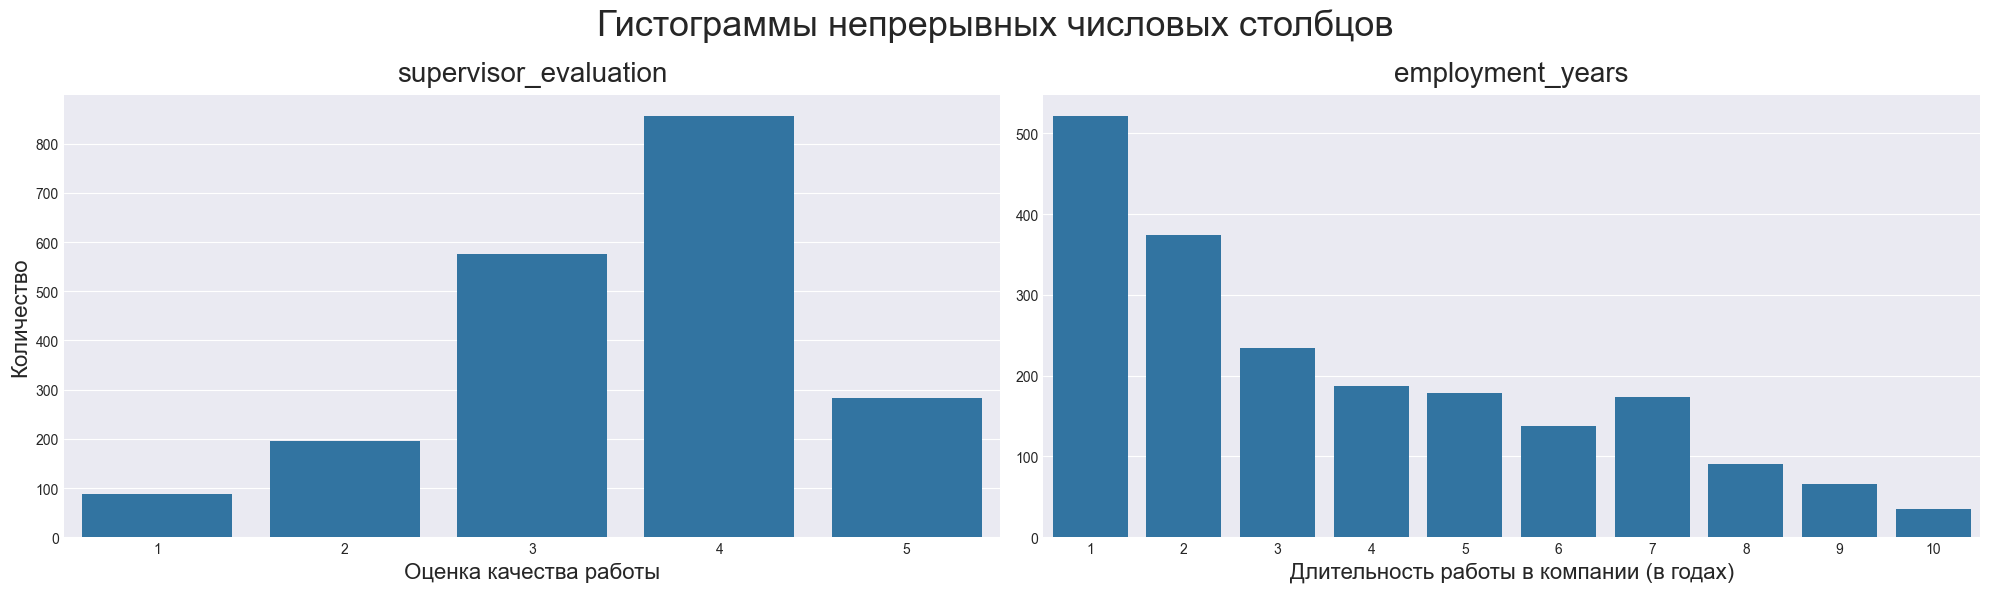

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=26)

sns.countplot(test_features, x='supervisor_evaluation', ax=axs[0])
sns.countplot(test_features, x='employment_years', ax=axs[1])

axs[0].set_title('supervisor_evaluation', fontsize=20)
axs[1].set_title('employment_years', fontsize=20)
axs[0].set_ylabel('Количество', fontsize=16)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('Оценка качества работы', fontsize=16)
axs[1].set_xlabel('Длительность работы в компании (в годах)', fontsize=16);

Посмотрим на частотные характеристики категориальных столбцов.

In [35]:
test_features.describe(exclude='number')

,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


Выведем столбчатые диаграммы категориальных столбцов.

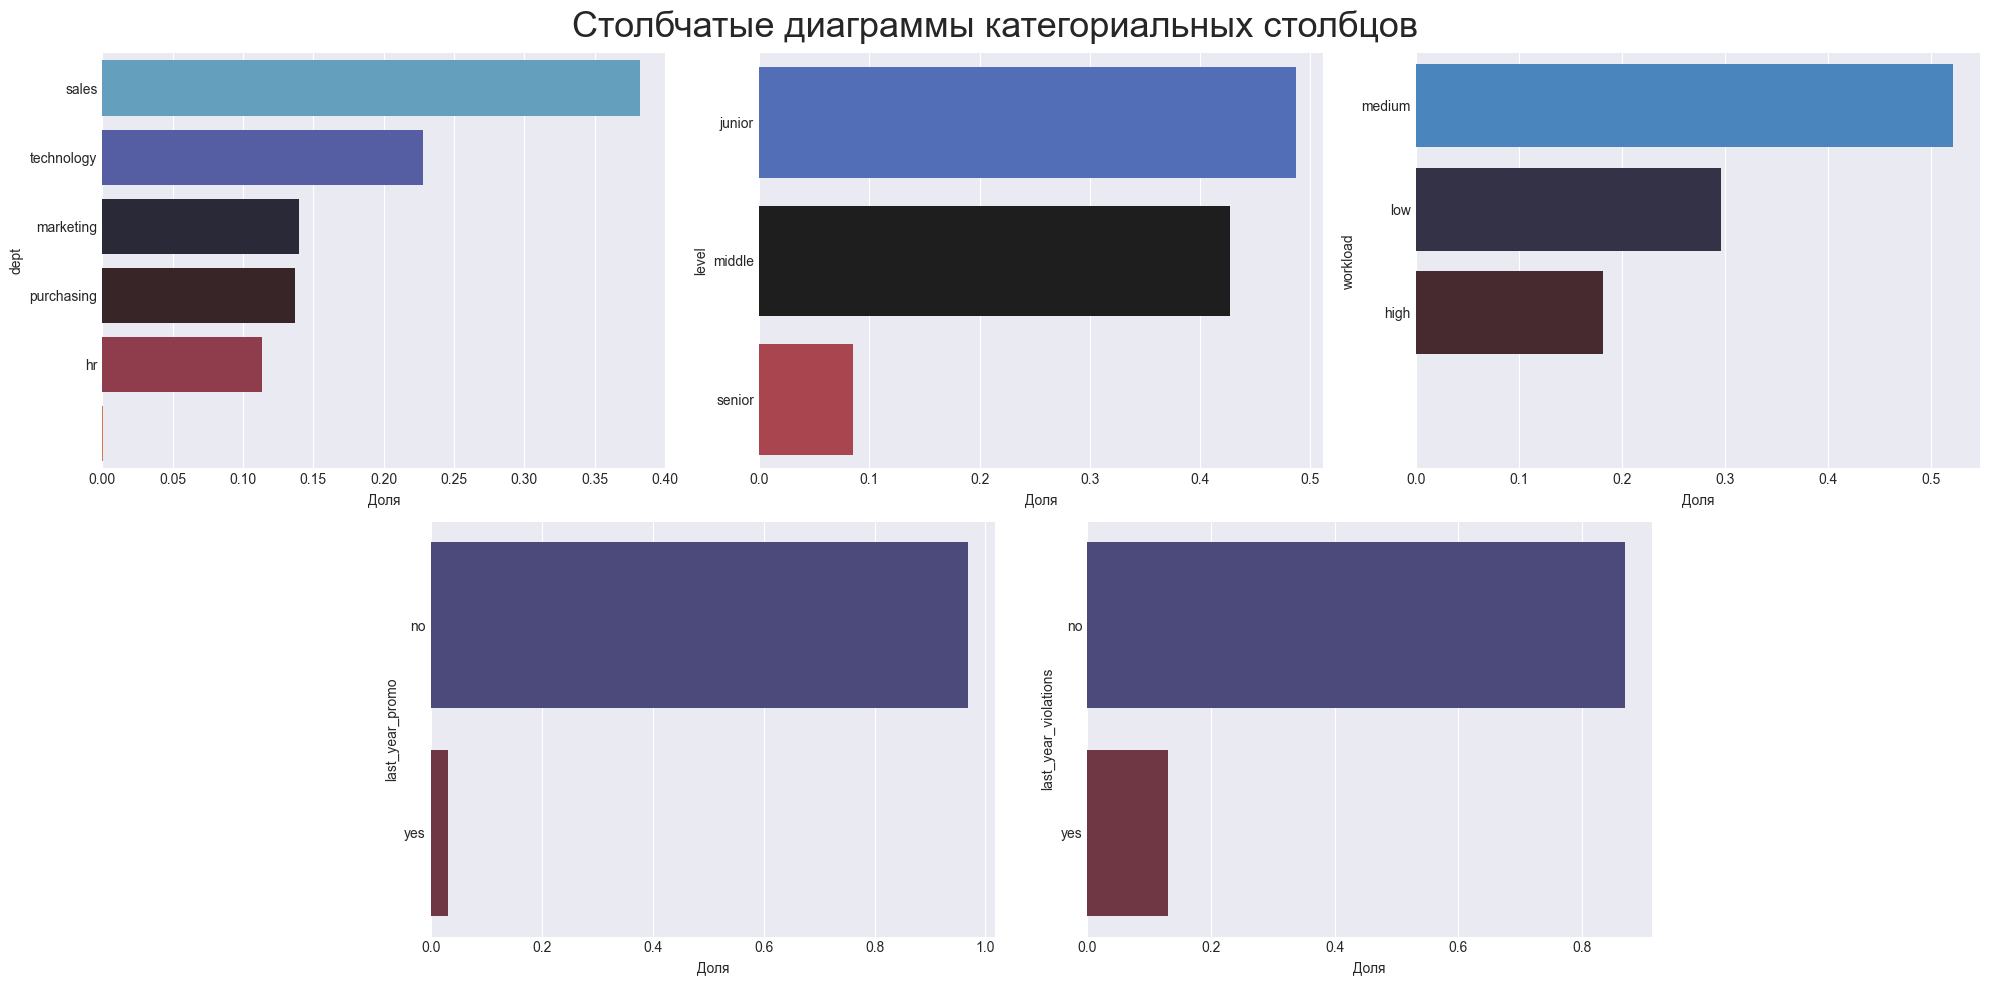

In [36]:
plt.figure(figsize=(20, 10))
plt.suptitle('Cтолбчатые диаграммы категориальных столбцов', fontsize=26)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

sns.barplot(data=test_features['dept'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax1)
sns.barplot(data=test_features['level'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax2)
sns.barplot(data=test_features['workload'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax3)
sns.barplot(data=test_features['last_year_promo'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax4)
sns.barplot(data=test_features['last_year_violations'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax5)

ax1.set_xlabel('Доля')
ax2.set_xlabel('Доля')
ax3.set_xlabel('Доля')
ax4.set_xlabel('Доля')
ax5.set_xlabel('Доля');

Данные в тестовой выборки очень похожи на данные из тренировочной, так что можно ожидать на обеих похожую метрику.

<a id='eda_test_ra'></a>
### Анализ test_target_job_satisfaction_rate

Выведем статистическое описание целевого признака тестовой выборки

In [37]:
test_target_job_satisfaction_rate.describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


Выведем гистограмму и ящик с усами

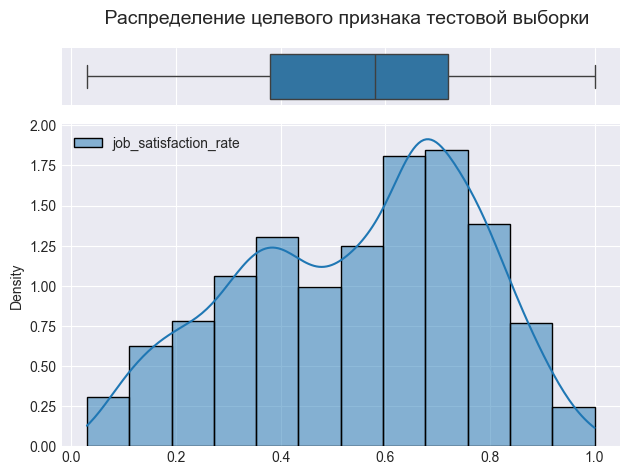

In [38]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle(12 * ' ' + 'Распределение целевого признака тестовой выборки', fontsize=14)

sns.boxplot(test_target_job_satisfaction_rate, ax=ax_box, orient='h')
sns.histplot(test_target_job_satisfaction_rate, bins=12, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

Как и в целевом признаке в тренировочной выборке, здесь нет выбросов. Пока что можно ожидать маленький разброс модели.

<a id='eda_train_quit'></a>
### Анализ train_quit

Выведем статистическое описание числовых столбцов

In [39]:
train_quit.describe()

,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308
std,2.601105,1.080243,16267.354906
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,24000.000000
50%,4.000000,3.000000,33600.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


Выведем гистограммы непрерывных числовых столбцов.

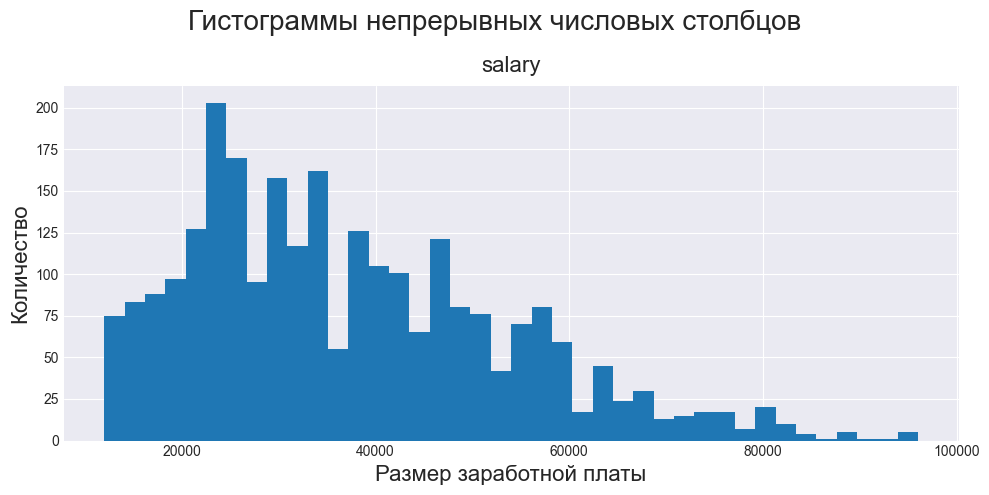

In [40]:
plt.figure(figsize=(10, 5))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=20)

plt.hist(train_quit['salary'], bins=40)

plt.title('salary', fontsize=16)
plt.ylabel('Количество', fontsize=16)
plt.xlabel('Размер заработной платы', fontsize=16);

Выведем столбцовые диаграммы дискретных числовых столбцов.

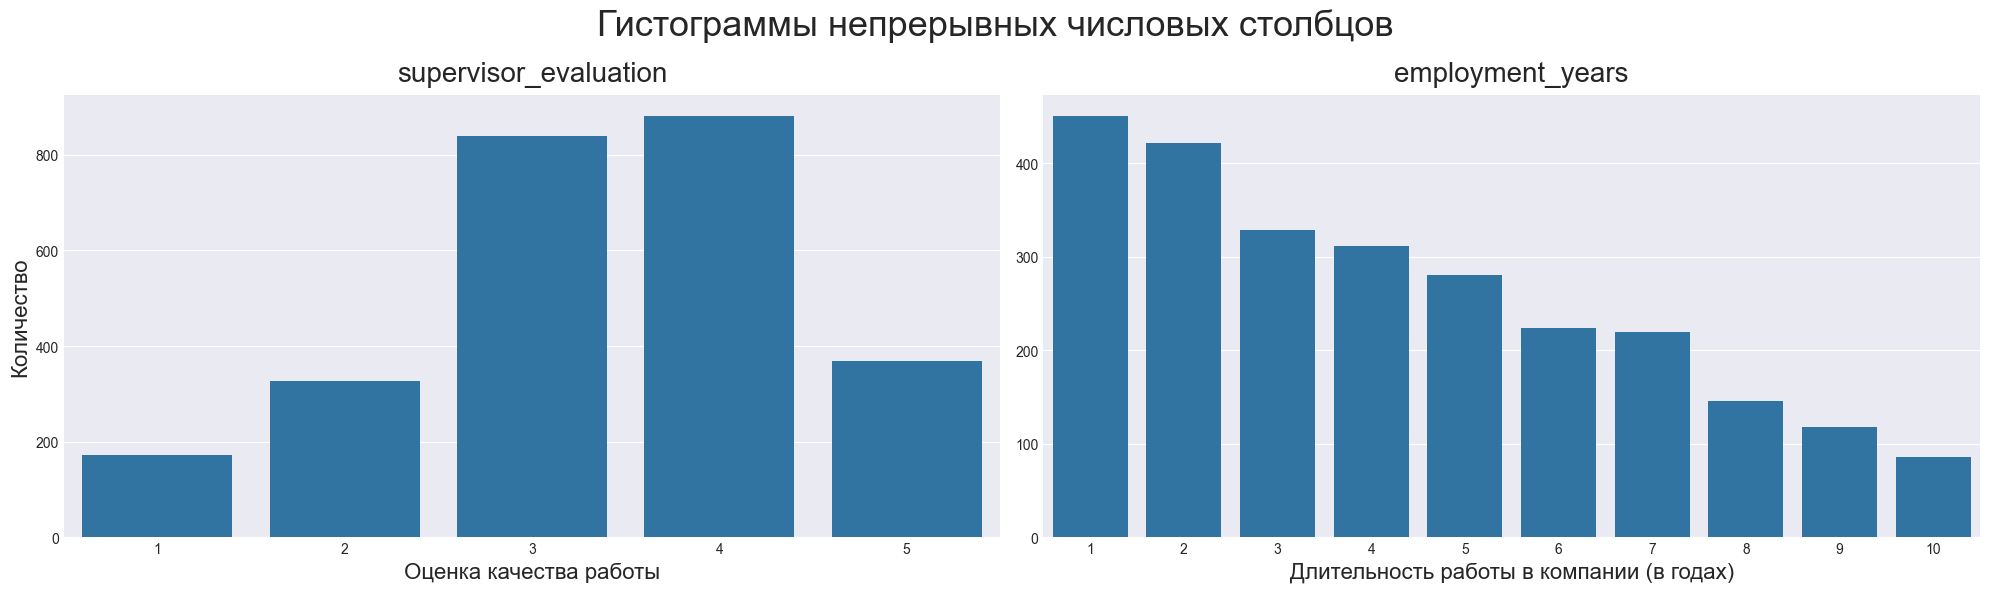

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=26)

sns.countplot(train_quit, x='supervisor_evaluation', ax=axs[0])
sns.countplot(train_quit, x='employment_years', ax=axs[1])

axs[0].set_title('supervisor_evaluation', fontsize=20)
axs[1].set_title('employment_years', fontsize=20)
axs[0].set_ylabel('Количество', fontsize=16)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('Оценка качества работы', fontsize=16)
axs[1].set_xlabel('Длительность работы в компании (в годах)', fontsize=16);

Посмотрим на частотные характеристики категориальных столбцов.

In [42]:
train_quit.describe(exclude='number')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,2587,2587,2587,2587,2587,2587
unique,5,3,3,2,2,2
top,sales,middle,medium,no,no,no
freq,805,1282,1244,2476,2111,1932


Выведем столбчатые диаграммы категориальных столбцов

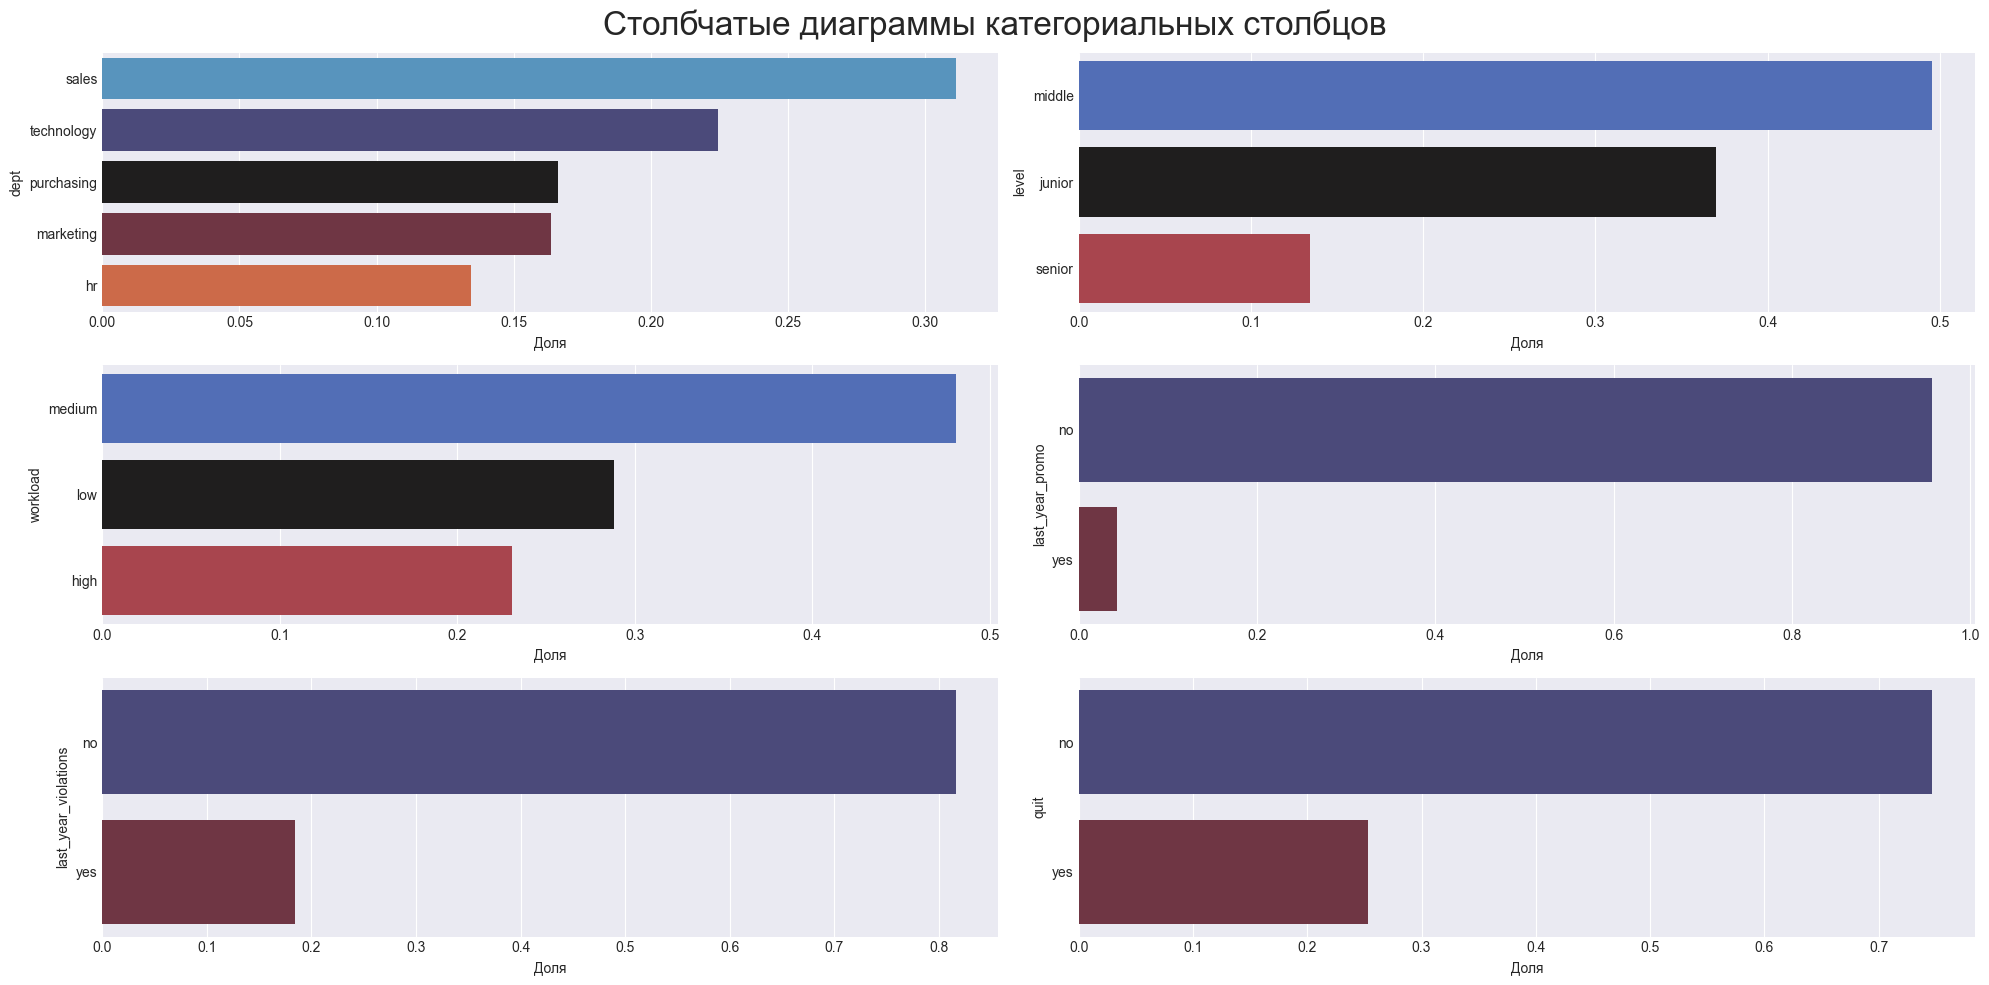

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10))
fig.suptitle('Cтолбчатые диаграммы категориальных столбцов', fontsize=24)

sns.barplot(data=train_quit['dept'].value_counts(normalize=True), orient='h', palette='icefire', ax=axs[0][0])
sns.barplot(data=train_quit['level'].value_counts(normalize=True), orient='h', palette='icefire', ax=axs[0][1])
sns.barplot(data=train_quit['workload'].value_counts(normalize=True), orient='h', palette='icefire', ax=axs[1][0])
sns.barplot(data=train_quit['last_year_promo'].value_counts(normalize=True), orient='h', palette='icefire', ax=axs[1][1])
sns.barplot(data=train_quit['last_year_violations'].value_counts(normalize=True), orient='h', palette='icefire', ax=axs[2][0])
sns.barplot(data=train_quit['quit'].value_counts(normalize=True), orient='h', palette='icefire', ax=axs[2][1])

axs[0][0].set_xlabel('Доля')
axs[0][1].set_xlabel('Доля')
axs[1][0].set_xlabel('Доля')
axs[1][1].set_xlabel('Доля')
axs[2][0].set_xlabel('Доля')
axs[2][1].set_xlabel('Доля');

Данные в `train_quit` достаточно сильно похожи на данные из [<ins>`train_job_satisfaction_rate`</ins>](#eda_ref).

Заметен существенный дисбаланс классов в целевой переменной (`quit`).

#### Составим портрет "уволившегося сотрудника"
Посмотрим на столбцовые диаграммы категориальных признаков уволившихся сотрудников

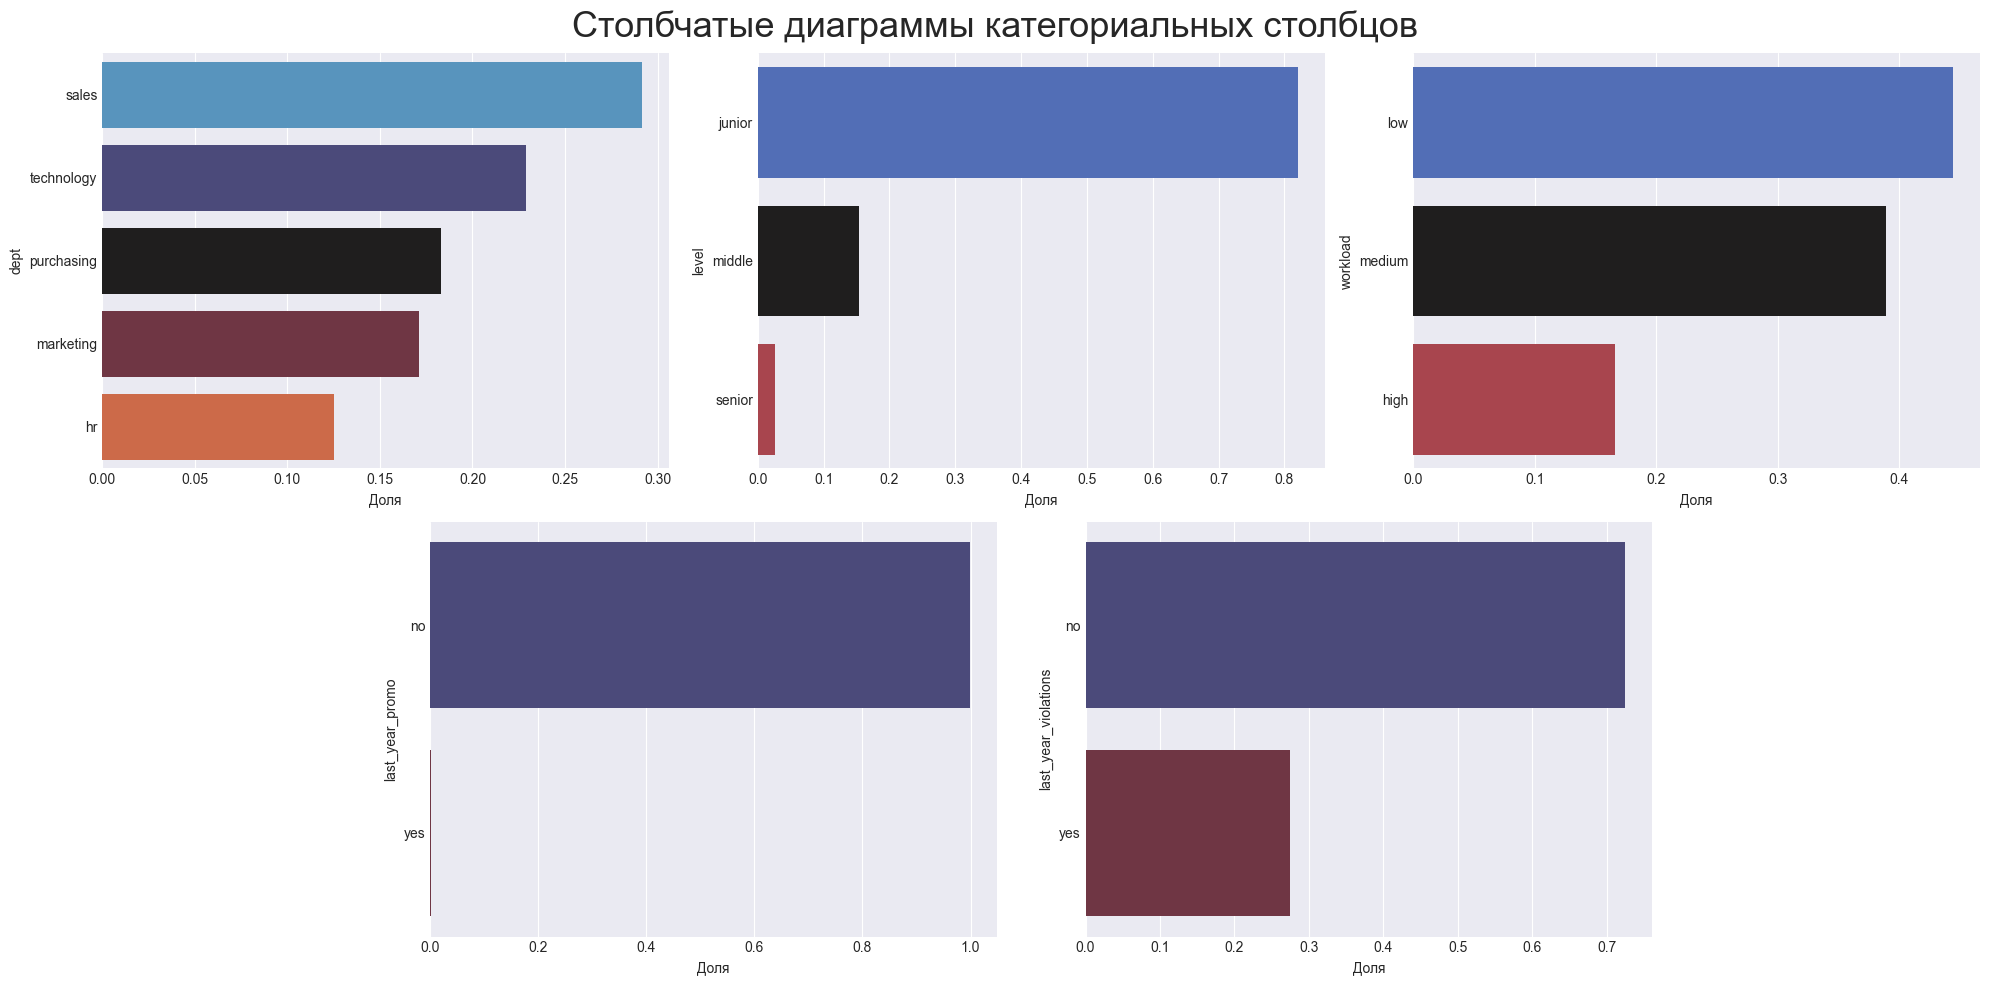

In [44]:
plt.figure(figsize=(20, 10))
plt.suptitle('Cтолбчатые диаграммы категориальных столбцов', fontsize=26)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

sns.barplot(data=train_quit[train_quit['quit'] == 'yes']['dept'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax1)
sns.barplot(data=train_quit[train_quit['quit'] == 'yes']['level'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax2)
sns.barplot(data=train_quit[train_quit['quit'] == 'yes']['workload'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax3)
sns.barplot(data=train_quit[train_quit['quit'] == 'yes']['last_year_promo'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax4)
sns.barplot(data=train_quit[train_quit['quit'] == 'yes']['last_year_violations'].value_counts(normalize=True), orient='h', palette='icefire', ax=ax5)

ax1.set_xlabel('Доля')
ax2.set_xlabel('Доля')
ax3.set_xlabel('Доля')
ax4.set_xlabel('Доля')
ax5.set_xlabel('Доля');

Чаще всего увольняются сотрудники уровня *junior*, у многих из которых небольшая нагрузка. Лишь один из уволившихся работников получил в течение года повышение. Также доля нарушений трудового договора среди рассматриваемых сотрудников выше средней.

Выведем гистограммы непрерывных числовых столбцов.

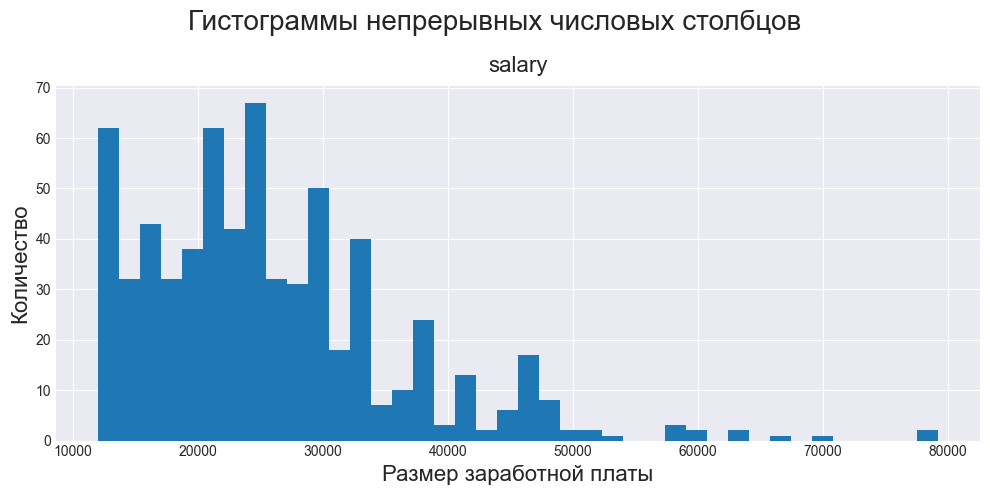

In [45]:
plt.figure(figsize=(10, 5))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=20)

plt.hist(train_quit[train_quit['quit'] == 'yes']['salary'], bins=40)

plt.title('salary', fontsize=16)
plt.ylabel('Количество', fontsize=16)
plt.xlabel('Размер заработной платы', fontsize=16);

Выведем столбцовые диаграммы дискретных числовых столбцов.

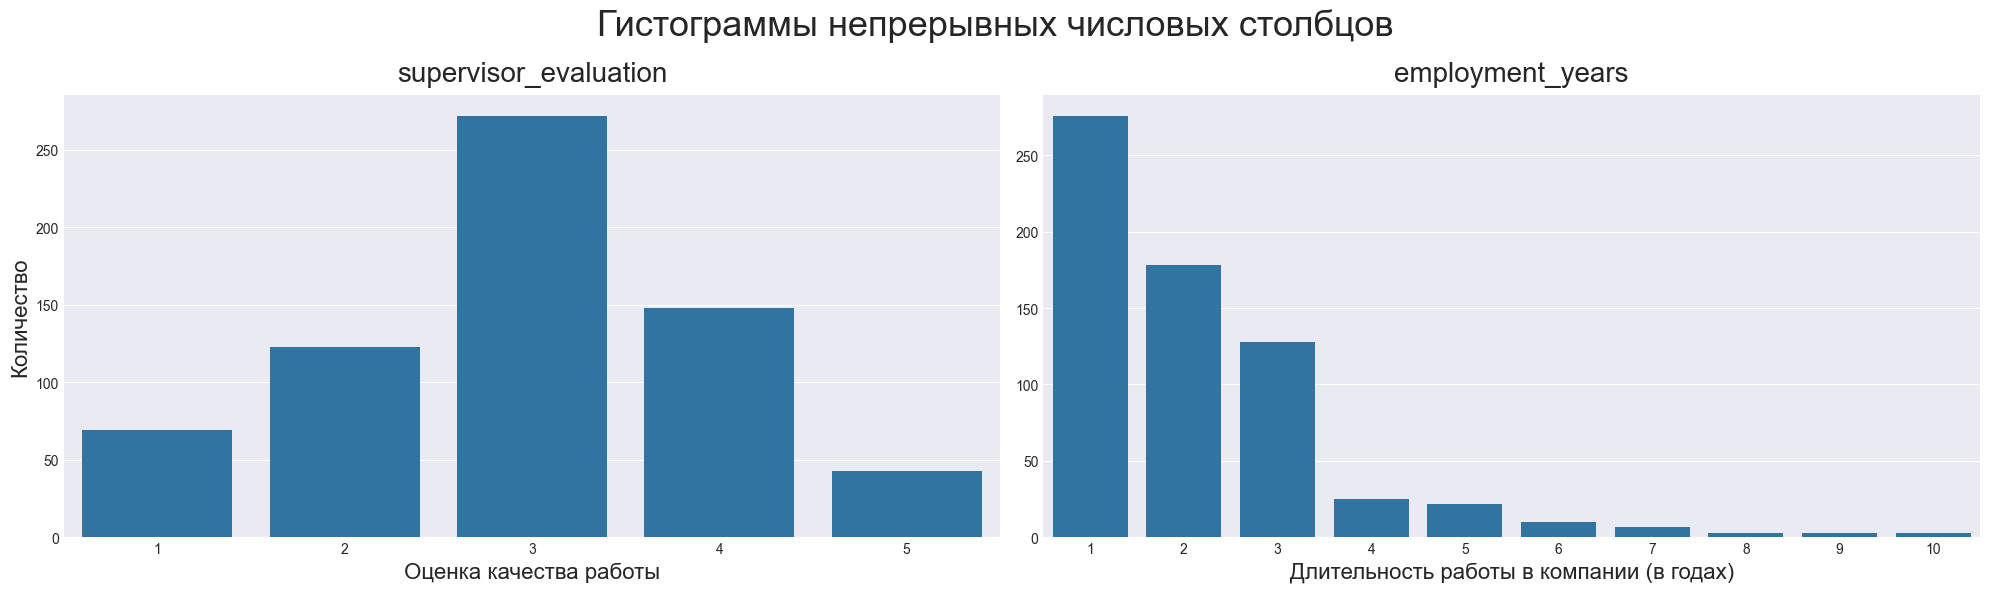

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.suptitle('Гистограммы непрерывных числовых столбцов', fontsize=26)

sns.countplot(train_quit[train_quit['quit'] == 'yes'], x='supervisor_evaluation', ax=axs[0])
sns.countplot(train_quit[train_quit['quit'] == 'yes'], x='employment_years', ax=axs[1])

axs[0].set_title('supervisor_evaluation', fontsize=20)
axs[1].set_title('employment_years', fontsize=20)
axs[0].set_ylabel('Количество', fontsize=16)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('Оценка качества работы', fontsize=16)
axs[1].set_xlabel('Длительность работы в компании (в годах)', fontsize=16);

Старые сотрудники увольняются достаточно редко. В среднем руководитель оценивает качество работы уволившегося сотрудника как удовлетворительное. Лишь малая часть из уволившихся получала в компании зарплату выше среднего.

<a id='eda_test_tar_quit'></a>
### Анализ test_target_quit

Выведем столбчатую диаграмму целевого признака (*уволится ли сотрудник*)

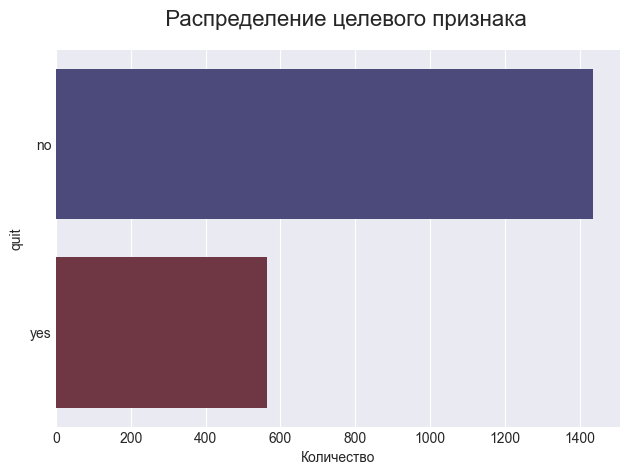

In [47]:
sns.barplot(data=test_target_quit['quit'].value_counts(), orient='h', palette='icefire')

plt.suptitle(10 * ' ' + 'Распределение целевого признака', fontsize=16)
plt.xlabel('Количество');

Здесь также есть дисбаланс классов, но так как он в тестировочной выборке, он никак не повлияет на модель при обучении.

<a id='hypo'></a>
### Проверим гипотезу о связи job_satisfaction_rate и quit

`id` сотрудников в тренировочных выборках не совпадают, поэтому для проверки гипотезы используем тестовую.

In [48]:
print(f'Количество общих id: \
{pd.concat([pd.Series(train_quit.index), pd.Series(train_job_satisfaction_rate.index)]).duplicated().sum()}')

Количество общих id: 0


In [49]:
connection = test_features.join(test_target_job_satisfaction_rate).join(test_target_quit)
connection

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56,yes
109582,technology,middle,low,3,no,no,2,21600,0.14,yes
305653,technology,junior,low,1,no,no,3,14400,0.11,yes


Выведем нормированную гистограмму

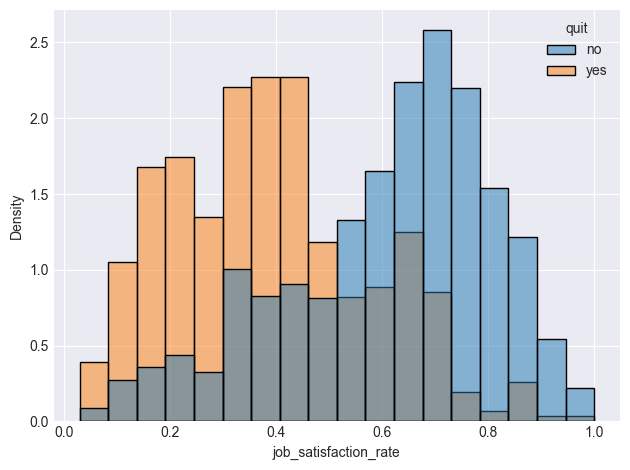

In [50]:
sns.histplot(data=connection, x='job_satisfaction_rate', hue='quit', stat='density', common_norm=False);

Cреди оставшихся сотрудников заметно меньше недовольных, звучит вполне правдоподобно.

*Выводы по исследовательскому анализу данных:*
* в целевом признаке 1-й задачи нет выбросов. Это значит, что нет особенно редких значений, которые могли бы помешать при моделировании
* при подготовке данных к обучению `employment_years` и `supervisor_evaluation` стоит сделать категориальными из-за их дискретной природы
* есть несколько записей с несвойственно большими для распределения значениями в `salary`, однако эти цифры весьма правдоподобны и вряд ли являются аномальными
* заметно маленькое число повышений сотрудников
* в целевом признаке 2-й задачи есть дисбаланс
* среди оставшихся сотрудников заметно меньше недовольных, чем среди ушедших
* чаще всего увольняются сотрудники уровня junior, у многих из которых небольшая нагрузка
* лишь один из уволившихся работников получил в течение года повышение
* доля нарушений трудового договора среди ушедших сотрудников выше средней

<a id='corr'></a>
## Корреляционный анализ

<a id='corr_rate'></a>
### Связь с целевым признаком в train_job_satisfaction_rate

Воспользуемся матрицей корреляций $\phi_k$

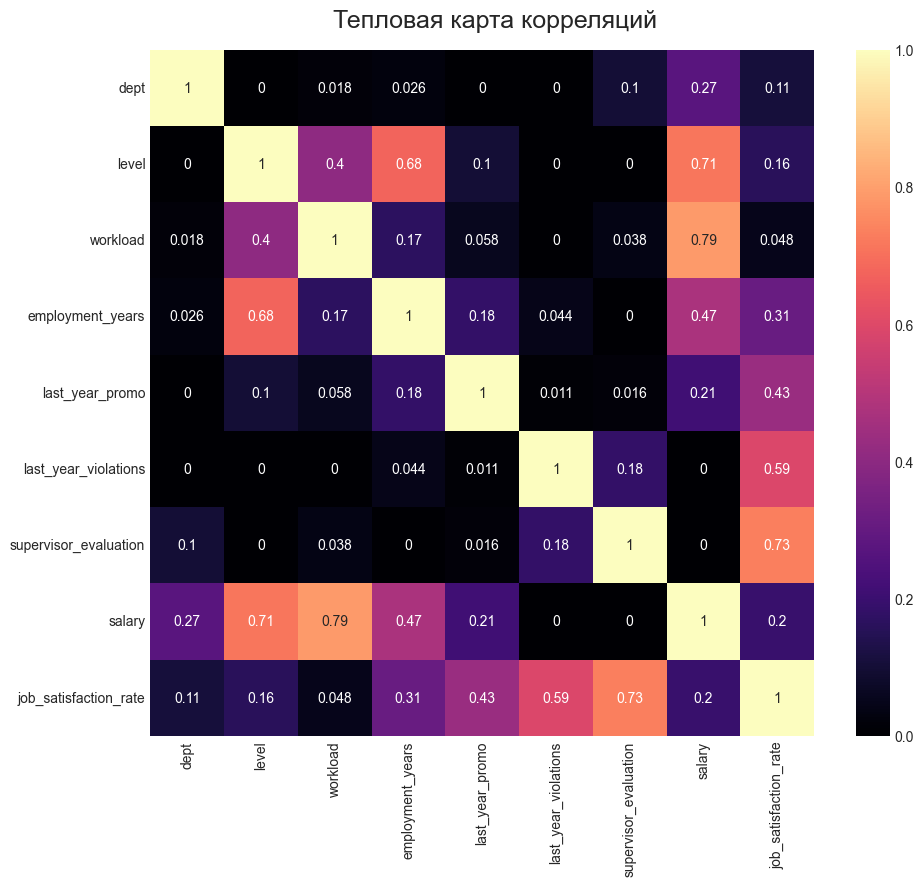

In [51]:
plt.figure(figsize=(10, 9))
plt.suptitle('Тепловая карта корреляций', fontsize=18)

sns.heatmap(train_job_satisfaction_rate.phik_matrix(interval_cols=['salary', 'job satisfaction rate']),
            annot=True, cmap='magma');

Многие признаки не коррелируют друг с другом, на что указывает большое количество чёрных клеток.

С целевой переменной лучше всего коррелирует `supervisor_evaluation`, также хороший уровень корреляции с `last_year_violations`. Корреляция с `employment_years`, `last_year_promo` и `salary` слабая, а с `dept`, `level`, `workload` – отсутствует.

Также можно заметить высокий уровень корреляции у `salary` с `level` и `workload`, а также у `employment_years` и `level`.

<a id='corr_quit'></a>
### Связь с целевым признаком в train_quit

Ещё раз воспользуемся матрицей корреляций $\phi_k$

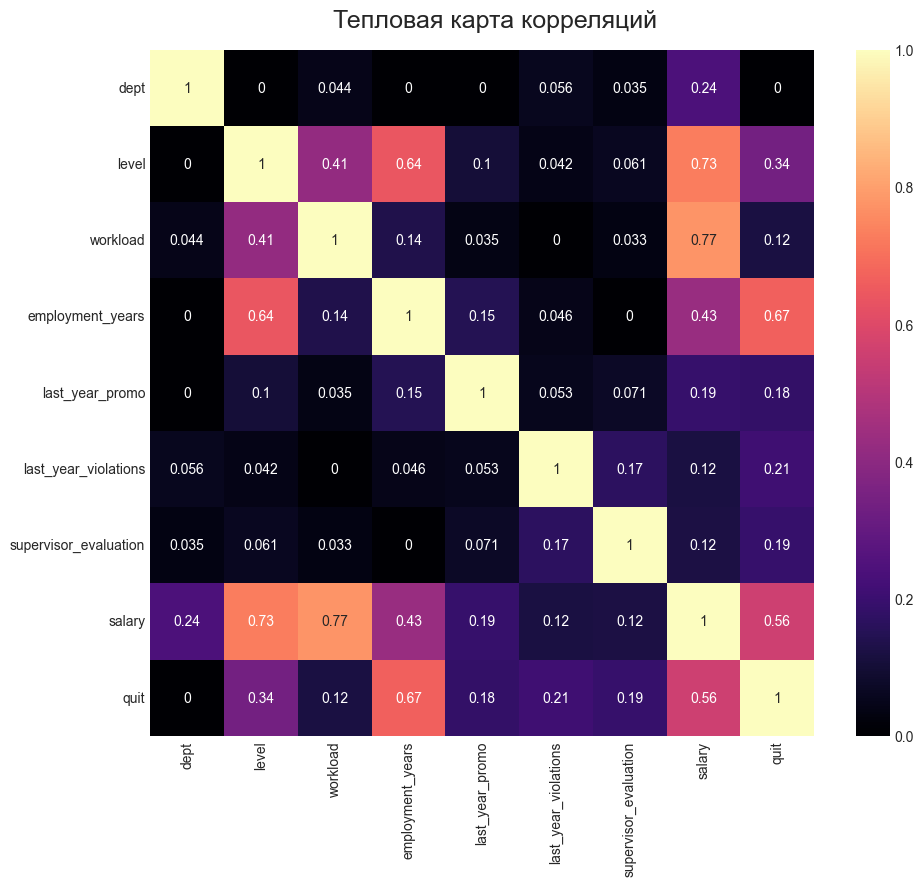

In [52]:
plt.figure(figsize=(10, 9))
plt.suptitle('Тепловая карта корреляций', fontsize=18)

sns.heatmap(train_quit.phik_matrix(interval_cols=['salary']),
            annot=True, cmap='magma');

Корреляция входных признаков в этом наборе данных и в `train_job_satisfaction_rate` похожа.

Здесь целевой признак лучше всего коррелирует с `employment_years`. Заметен хороший уровень корреляции с `salary`. Есть небольшая корреляция с `level`, `last_year_promo`, `last_year_violations` и `supervisor_evaluation`, с `workload` – очень слабая, а с `dept` её нет.

<a id='corr_test'></a>
### Связь с целевыми признаками в тестовой выборке

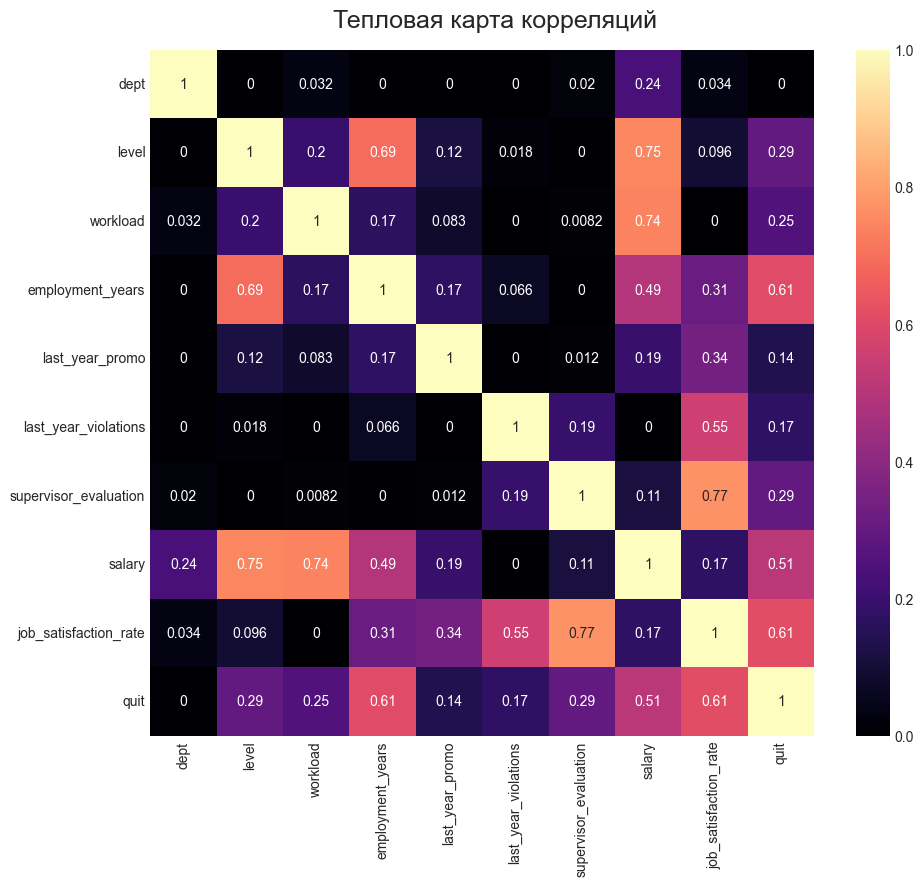

In [53]:
plt.figure(figsize=(10, 9))
plt.suptitle('Тепловая карта корреляций', fontsize=18)

sns.heatmap(test_features.join(test_target_job_satisfaction_rate).join(test_target_quit).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
            annot=True, cmap='magma');

Зависимости в тестовой выборке похожи на зависимости в тренировочных данных.

*Выводы по корреляционному анализу:*
* многие признаки не коррелируют друг с другом
* высокий уровень корреляции заметен у `salary` с `level` и `workload`, а также у `employment_years` и `level`
* с целевой переменной в `train_job_satisfaction_rate` лучше всего коррелирует `supervisor_evaluation`, также хороший уровень корреляции с `last_year_violations`. Корреляция с `employment_years`, `last_year_promo` и `salary` слабая, а с `dept`, `level`, `workload` – отсутствует.
* в `train_quit` целевой признак лучше всего коррелирует с `employment_years`. Заметен хороший уровень корреляции с `salary`. Есть небольшая корреляция с `level`, `last_year_promo`, `last_year_violations` и `supervisor_evaluation`, с `workload` – очень слабая, а с `dept` её нет.
* зависимости в тестовой выборке похожи на зависимости в тренировочных данных

Теперь, когда нам известно, какие признаки сильнее всего влияют на предсказание, мы можем начать моделирование.

<a id='first'></a>
## Задача 1. Предсказание уровня удовлетворённости сотрудника
Первая задача представляет собой задачу регресии: нам нужно предсказать уровень удовлетворённости сотрудника и оценить качество модели метрикой *SMAPE (symmetric mean absolute percentage error)*.

<a id='prep1'></a>
### Подготовка данных

Метрику будем считать на кросс-валидации, поэтому делить данные на тестовую, валидационную и тренировочную выборки не придётся. Отделим от `train_job_satisfaction_rate` столбец с целевой переменной.

In [54]:
X_train_reg = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train_reg = train_job_satisfaction_rate['job_satisfaction_rate']
print(f'X_train_reg - {X_train_reg.shape}')
print(f'y_train_reg - {y_train_reg.shape}')

X_train_reg - (3755, 8)
y_train_reg - (3755,)


Создадим пайплайн, чтобы закодировать `level`, `workload`, `last_year_promo` и `last_year_violations` при помощи OrdinalEncoder и заполнить неизвестные при обучении значения, если таковые появятся, модой. У `level` и `workload` прослеживается ранговость, поэтому OrdinalEncoder является наиболее подходящим вариантом их кодирования.

In [55]:
ord_pipe = Pipeline(
    [
        ('ord_imputer_bfr', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=[['junior', 'middle', 'senior'],
                                                                                                         ['low', 'medium', 'high'],
                                                                                                         ['no', 'yes'],
                                                                                                         ['no', 'yes']])),
        ('ord_imputer_aftr', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим *ColumnTransformer*: `dept` закодируем при помощи *OneHotEncoder*, `salary` масштабируем. `employment_years` и `supervisor_evaluation` из-за их дискретности будем считать категориальными и изменять не будем.

In [56]:
preprocessing = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist'), ['dept']),
        ('ord', ord_pipe, ['level', 'workload', 'last_year_promo', 'last_year_violations']),
        ('num', StandardScaler(), ['salary'])
    ],
    remainder='passthrough'
)
pd.DataFrame(preprocessing.fit_transform(X_train_reg), columns=preprocessing.get_feature_names_out())

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__dept_nan,ord__level,ord__workload,ord__last_year_promo,ord__last_year_violations,num__salary,remainder__employment_years,remainder__supervisor_evaluation
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.694908,2.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.261989,2.0,5.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.492322,1.0,2.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.093615,4.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.774649,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3750,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,3.052939,6.0,4.0
3751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.934132,2.0,3.0
3752,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.694908,7.0,5.0
3753,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.694908,2.0,3.0


<a id='metric'></a>
### Имплементация метрики SMAPE
По условиям заказчика, лучшую модель нужно выбрать на основе метрики *SMAPE* (symmetric mean absolute percentage error). Ниже представлена её формула:

$$ SMAPE = \frac{100}{n}\sum_{i=1}^n\frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|)/2},$$
где:
* $y_i$ — фактическое значение целевого признака для объекта с порядковым номером i в выборке
* $\hat{y_i}$ – предсказанное значение целевого признака для объекта с порядковым номером i в выборке
* $n$ — количество объектов в выборке

В библиотеке *sklearn* нет готовой функции, возвращающей значение *SMAPE*, так что нам придётся реализовать её самостоятельно.

In [57]:
def SMAPE(y_test, y_pred):
    return 100 / len(y_test) * np.sum(np.abs(np.array(y_test).reshape(len(y_test), 1) - np.array(y_pred).reshape(len(y_test), 1)) / 
                                      (np.abs(np.array(y_test).reshape(len(y_test), 1)) + np.abs(np.array(y_pred).reshape(len(y_test), 1)))) * 2
smape_score = make_scorer(SMAPE, greater_is_better=False)

Теперь мы можем удобно считать нужную нам метрику. Критерий успеха решения первой задачи: *SMAPE* $\leq$ 15 на тестовой выборке.

<a id='model1'></a>
### Моделирование и подбор гиперпараметров
Создадим пайплайн, гиперпараметры которого будем перебирать.

In [58]:
pipe = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('model', LinearRegression())
    ]
)

Попробуем посчитать метрики на нескольких моделях с разными гиперпараметрами. Перебор моделей и их гиперпараметров будем осуществлять при помощи RandomizedSearchCV.

In [59]:
param_grid = [
    {
        'model': [LinearRegression()],
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [Lasso(random_state=42), Ridge(random_state=42)],
        'model__alpha': np.insert(np.linspace(0, 10, 11), 1, 0.5),
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [KNeighborsRegressor()],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['cityblock', 'euclidean'],
        'model__n_neighbors': range(5, 20),
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [DecisionTreeRegressor(random_state=42)],
        'model__max_depth': range(2, 30),
        'model__min_samples_split': range(2, 30),
        'model__min_samples_leaf': range(2, 30),
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    }
]
rand_search = RandomizedSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring=smape_score,
    n_jobs=-1,
    random_state=42,
    n_iter=1000
)
rand_search.fit(X_train_reg, y_train_reg)
print(f'SMAPE = {abs(rand_search.best_score_)}')
rand_search.best_estimator_

SMAPE = 15.12548059760969


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imputer_bfr',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               '...
                                                                                               'high'],
                                                                                              ['no',
                                                                                               'yes'],
                                                                                              ['no',
                                                                                               'yes']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('ord_imputer_aftr',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=19, min_samples_leaf=2,
                                       min_samples_split=8, random_state=42))])

Метрика получилась обнадёживающей. Лучше всего справилась модель *DecisionTreeRegressor*, что было вполне ожидаемо из-за преобладающего количества категориальных признаков в данных.

Сделаем предсказание на тестовой выборке.

In [60]:
print(f'SMAPE = {abs(smape_score(rand_search, test_features.sort_index(), test_target_job_satisfaction_rate.sort_index()))}')
# данные нужно отсортировать по индексу, чтобы индексы входных данных и целевой переменной совпадали

SMAPE = 13.352118030111223


Модель получилась достаточно точной и её метрика соответствует требованиям заказчика, который требовал, чтобы на тестовой выборке *SMAPE* было не более 15.

Проверим модель на адекватность, сделав предсказания на константной модели.

In [61]:
dummy_reg = DummyRegressor()
dummy_reg.fit(X_train_reg, y_train_reg)
print(f'SMAPE = {abs(smape_score(dummy_reg, test_features.sort_index(), test_target_job_satisfaction_rate.sort_index()))}')

SMAPE = 38.26225790202238


*DecisionTreeRegressor* справляется с задачей заметно лучше константной модели.

Посмотрим на диаграму рассеяния и гистограмму остатков.

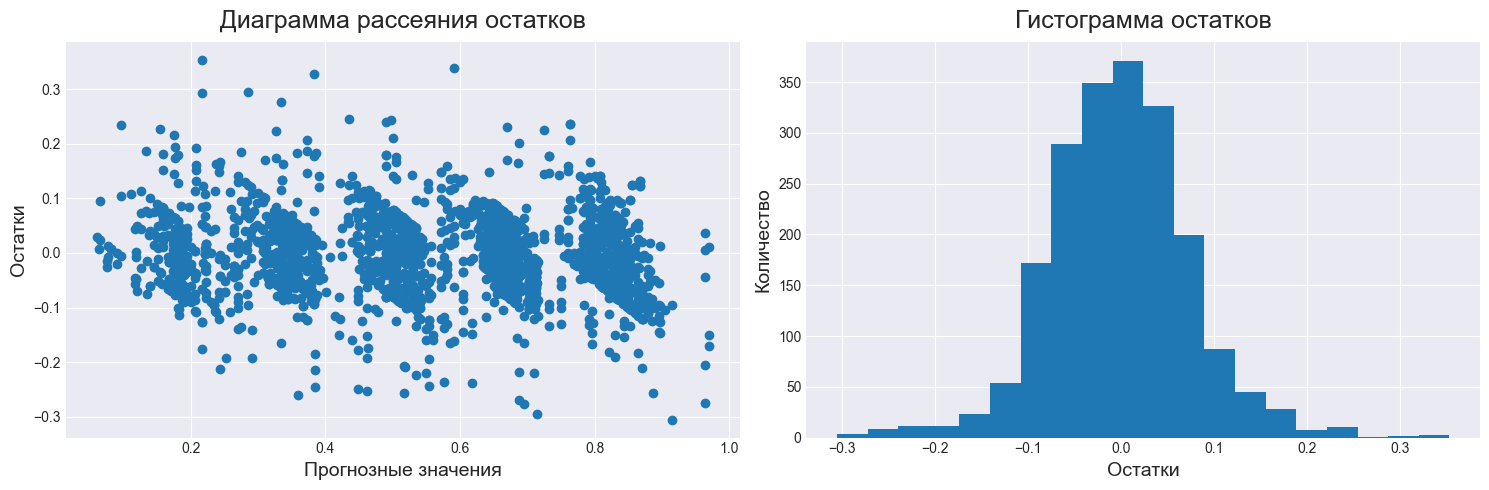

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

predictions = rand_search.predict(test_features.sort_index())
residuals = test_target_job_satisfaction_rate.sort_index() - predictions.reshape(2000, 1)

axs[0].scatter(predictions, residuals)
axs[0].set_title('Диаграмма рассеяния остатков', fontsize=18)
axs[0].set_xlabel('Прогнозные значения', fontsize=14)
axs[0].set_ylabel('Остатки', fontsize=14)

axs[1].hist(residuals, bins=20)
axs[1].set_title('Гистограмма остатков', fontsize=18)
axs[1].set_xlabel('Остатки', fontsize=14)
axs[1].set_ylabel('Количество', fontsize=14);

На диаграмме рассеяния видно, что у модели есть 5 диапазонов, в которые наиболее часто попадают прогнозные значения, что скорее всего является особенностью *DecisionTreeRegressor*. Несмотря на это, наибольшая доля предсказаний отличается от истинных значений не более, чем на 0.1 – это наиболее чётко заметно на гистограмме. Какой-либо зависимости остатков от прогнозных значений не видно, распределение остатков нормальное.

*Выводы по задаче предсказания уровня удовлетворённости сотрудника:*
* лучше всего с задачей справилась модель *DecisionTreeRegressor(max_depth=19, min_samples_leaf=2, min_samples_split=8, random_state=42)*
* признак `dept` был закодирован при помощи OneHotEncoder
* `level`, `workload`, `last_year_promo` и `last_year_violations` были закодированы при помощи OrdinalEncoder
* количественный признак `salary` был нормализирован
* SMAPE на тестовой выборке равен около 13.35
* остатки модели распределены нормально и не зависят от прогнозных значений

<a id='second'></a>
## Задача 2. Предсказание увольнения сотрудника из компании
Вторая задача является задачей классификации. Критерий успеха: ROC-AUC $\geq$ 0.91 на тестовой выборке.

<a id='prep2'></a>
### Подготовка данных

Отделим от `train_quit` столбец с целевой переменной.

In [63]:
X_train_clf = train_quit.drop('quit', axis=1).sort_index()
y_train_clf = train_quit['quit'].sort_index()
print(f'X_train_clf - {X_train_clf.shape}')
print(f'y_train_clf - {y_train_clf.shape}')

X_train_clf - (2587, 8)
y_train_clf - (2587,)


Есть дисбаланс классов, но учитывая, что мы оцениваем метрику ROC-AUC, можно ничего с этим не делать, ведь на эту метрику он влияет достаточно слабо.

Добавим новый входной признак: в ходе исследовательского анализа данных выяснилось, что уровень удовлетворённости сотрудника влияет на факт его увольнения. Предскажем уровень удовлетворённости при помощи первой модели.

In [64]:
X_train_clf['job_satisfaction_rate'] = rand_search.predict(X_train_clf)
X_train_clf.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,0.345714
100459,purchasing,junior,medium,3,no,no,3,21600,0.311667
100858,sales,junior,medium,2,no,no,4,25200,0.838750
101374,technology,middle,low,8,no,no,3,22800,0.378571
102155,technology,middle,high,8,no,no,4,57600,0.644000


Закодируем целевой признак

In [65]:
label_encoder = LabelEncoder()
y_train_clf = label_encoder.fit_transform(y_train_clf)

Добавим в *ColumnTransformer* из предыдущей задачи масштабирование `job_satisfaction_rate`

In [66]:
preprocessing_clf = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist'), ['dept']),
        ('ord', ord_pipe, ['level', 'workload', 'last_year_promo', 'last_year_violations']),
        ('num', StandardScaler(), ['salary', 'job_satisfaction_rate'])
    ],
    remainder='passthrough'
)
pd.DataFrame(preprocessing_clf.fit_transform(X_train_clf), columns=preprocessing_clf.get_feature_names_out())

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ord__level,ord__workload,ord__last_year_promo,ord__last_year_violations,num__salary,num__job_satisfaction_rate,remainder__employment_years,remainder__supervisor_evaluation
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.027267,-0.773543,3.0,2.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.953486,-0.927469,3.0,3.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.732141,1.455430,2.0,4.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.879704,-0.624998,8.0,3.0
4,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.259963,0.574982,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2582,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.101049,-0.177751,5.0,3.0
2583,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.805922,-1.651892,3.0,2.0
2584,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.953486,-1.929605,1.0,1.0
2585,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.174831,1.118783,5.0,4.0


<a id='model2'></a>
### Моделирование и подбор гиперпараметров
Создадим пайплайн, гиперпараметры которого будем перебирать.

In [67]:
pipe_clf = Pipeline(
    [
        ('preprocessing', preprocessing_clf),
        ('model', LogisticRegression(random_state=42))
    ]
)

Попробуем посчитать метрики на нескольких моделях с разными гиперпараметрами. Перебор моделей и их гиперпараметров будем осуществлять при помощи RandomizedSearchCV.

In [68]:
param_grid_clf = [
    {
        'model': [KNeighborsClassifier()],
        'model__metric': ['cityblock', 'euclidean'],
        'model__n_neighbors': range(5, 50),
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=42, solver='liblinear')],
        'model__penalty': ['l1', 'l2'],
        'model__C': np.linspace(0, 10, 11),
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [SVC(random_state=42, probability=True)],
        'model__kernel': ['rbf', 'sigmoid'],
        'model__C': np.linspace(0, 10, 11),
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [SVC(random_state=42, kernel='poly', probability=True)],
        'model__degree': range(2, 6),
        'model__C': np.linspace(0, 10, 11),
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [DecisionTreeClassifier(random_state=42)],
        'model__max_depth': range(2, 21),
        'model__min_samples_split': range(2, 40),
        'model__min_samples_leaf': range(2, 40),        
        'preprocessing__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    }
]
rand_search_clf = RandomizedSearchCV(
    pipe_clf,
    param_grid_clf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    n_iter=1000
)
rand_search_clf.fit(X_train_clf, y_train_clf)
print(f'ROC_AUC = {abs(rand_search_clf.best_score_)}')
rand_search_clf.best_estimator_

ROC_AUC = 0.9071178088329516


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imputer_bfr',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               '...
                                                                                               'yes']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('ord_imputer_aftr',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', StandardScaler(),
                                                  ['salary',
                                                   'job_satisfaction_rate'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=18,
                                        min_samples_split=32,
                                        random_state=42))])

Получилась неплохая метрика. В этот раз лучшей опять оказалась "деревянная" модель.

Сделаем предсказание на тестовой выборке.

In [69]:
test_features_clf = test_features.copy()
test_features_clf['job_satisfaction_rate'] = rand_search.predict(test_features)
print('ROC_AUC =', roc_auc_score(label_encoder.transform(test_target_quit.sort_index()), rand_search_clf.predict_proba(test_features_clf.sort_index())[:, 1]))

ROC_AUC = 0.9155751792805074


Метрика на тестовой выборке соответствует требованиям заказчика (не менее 0.91)

Проверим модель на адекватность, для этого сделаем предсказания на константной модели.

In [70]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_clf, y_train_clf)
print('ROC_AUC =', roc_auc_score(label_encoder.transform(test_target_quit.sort_index()), dummy_clf.predict_proba(test_features_clf.sort_index())[:, 1]))

ROC_AUC = 0.5


Здесь наша модель не подвела, её метрика значительно лучше.

*Выводы по задаче предсказания увольнения сотрудника из компании:*
* лучше всего с задачей справилась модель *DecisionTreeClassifier(max_depth=4, min_samples_leaf=18, min_samples_split=32, random_state=42)*
* использовался *ColumnTransformer* из первой задачи
* в тренировочную выборку были добавлены предсказания при помощи первой модели
* количественные признаки не были изменены
* ROC_AUC на тестовой выборке приблизительно равен 0.92

<a id='summary'></a>
## Вывод
В ходе исследования были построены две модели для предсказания оттока сотрудников, позволяющие снизить риски компании и избежать финансовых потерь:
* Первая модель может быть использована для предсказания уровня удовлетворённости сотрудника
* Вторая модель может предсказать увольнение сотрудника из компании

**Исходные данные**

Компания предоставила данные с характеристиками сотрудников компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

В нашем распоряжении есть пять файлов с табличными данными в формате csv: `train_job_satisfaction_rate`, `test_features`, `test_target_job_satisfaction_rate`, `train_quit` и `test_target_quit`. Входные признаки тестовой выборки одинаковы для обеих задач.

В данных есть следующие признаки:
* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

*С данными были проведены предобработка, исследовательский и корреляционный анализы.*

В ходе предобработки мы избавились от дубликатов и пропусков в обучающих выборках, а также сделали `id` индексом для каждого датафрейма.

*Исследовательский анализ данных показал, что:*
* в целевом признаке 1-й задачи нет выбросов. Это значит, что нет особенно редких значений, которые могли бы помешать при моделировании
* при подготовке данных к обучению `employment_years` и `supervisor_evaluation` стоит сделать категориальными из-за их дискретной природы
* есть несколько записей с несвойственно большими для распределения значениями в `salary`, однако эти цифры весьма правдоподобны и вряд ли являются аномальными
* заметно маленькое число повышений сотрудников
* в целевом признаке 2-й задачи есть дисбаланс
* среди оставшихся сотрудников заметно меньше недовольных, чем среди ушедших
* чаще всего увольняются сотрудники уровня *junior*, у многих из которых небольшая нагрузка
* лишь один из уволившихся работников получил в течение года повышение
* доля нарушений трудового договора среди ушедших сотрудников выше средней

*Корреляционный анализ данных выявил следующие закономерности:*
* многие признаки не коррелируют друг с другом
* высокий уровень корреляции заметен у `salary` с `level` и `workload`, а также у `employment_years` и `level`
* с целевой переменной в `train_job_satisfaction_rate` лучше всего коррелирует `supervisor_evaluation`, также хороший уровень корреляции с `last_year_violations`. Корреляция с `employment_years`, `last_year_promo` и `salary` слабая, а с `dept`, `level`, `workload` – отсутствует.
* в `train_quit` целевой признак лучше всего коррелирует с `employment_years`. Заметен хороший уровень корреляции с `salary`. Есть небольшая корреляция с `level`, `last_year_promo`, `last_year_violations` и `supervisor_evaluation`, с `workload` – очень слабая, а с `dept` её нет.
* зависимости в тестовой выборке похожи на зависимости в тренировочных данных

***Моделирование***

**Задача 1**

* лучше всего с первой задачей справилась модель *DecisionTreeRegressor(max_depth=19, min_samples_leaf=2, min_samples_split=8, random_state=42)*
* признак `dept` был закодирован при помощи OneHotEncoder
* `level`, `workload`, `last_year_promo` и `last_year_violations` были закодированы при помощи OrdinalEncoder
* количественный признак `salary` был нормализирован
* SMAPE на тестовой выборке равен около 13.35
* остатки модели распределены нормально и не зависят от прогнозных значений

**Задача 2**

* лучше всего со второй задачей справилась модель *DecisionTreeClassifier(max_depth=4, min_samples_leaf=18, min_samples_split=32, random_state=42)*
* использовался *ColumnTransformer* из первой задачи
* в тренировочную выборку были добавлены предсказания при помощи первой модели
* количественные признаки не были изменены
* ROC_AUC на тестовой выборке приблизительно равен 0.92

В дальнейшем при помощи полученных моделей можно делать регулярные проверки состояния удовлетворённости работников. Вовремя обнаруженный сотрудник, который в перспективе может уйти, будет сигналом для руководства о надобности принятия мер по сохранению штата.